# Paper Figures, Mapped Correlations, & other analysis figures 

This notebook will be used to:
- Show a map of the ecoregions used in this paper
- The coeficients of Lasso regression for each ecoregion. Variables that do not show up are not chosen by the Lasso. 
    - TODO: significance for chosen variables. 
- Show the historical variance explained by regularized regression for atmos and plant centric variables. 

The data shown in this notebook's figures are generated by train_burn_area_classifier.ipynb

### TODO: 
- Update the MTBS burn area loaded for the time series plot at the end. Do not nessisaraly want the log10 transformed burn area. 
- Update the diff years to have the same number of years spanned as the training data. For when we show the diff of CMIP5 mean values from now to future period. 
- 


In [1]:
# Chosen experiment
experiment = "no_logs" # sigma_scaled

In [2]:
import numpy as np
from matplotlib import pylab as plt
from matplotlib import cm
from matplotlib import pyplot
import matplotlib.gridspec as gridspec
import matplotlib
import seaborn as sns
import pandas as pd 
import geopandas as geo
import seaborn as sns
import os
import pickle
from matplotlib.patches import Patch # For making custom legends 
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

In [3]:
dataDir = os.path.join('..', 'Data', 'Analysis', experiment)
geo_df_file = os.path.join(dataDir, 'results_geo_df')

#### Load the Lasso coeficient and $R^2$ values created by train_burn_area_classifier.ipynb
- This is a GeoDataGrame where the shapes and associated data are stored as a single data structure

In [4]:
divisions = geo.read_file(geo_df_file)
divisions.index = divisions.division
divisions.columns

Index(['AREA', 'division', 'OLS_r2', 'lasso_r2', 'lasso_alph', 'atmos_r2',
       'atmos_alph', 'plant_r2', 'plant_alph', 'geometry'],
      dtype='object')

In [5]:
usa = geo.read_file('../Data/GIS/cb_2017_us_state_500k')

Set static division colors 

In [6]:
n_div = divisions.shape[0]
tab10 = cm.get_cmap('Set3', n_div)
division_colors = tab10(range(n_div))
division_colors[0][0:3]
division_colors_hex = []
for i in range(n_div) :
    division_colors_hex.append(matplotlib.colors.to_hex(division_colors[i][0:3]))
    
division_colors_hex
divisions['division_colors'] = division_colors_hex

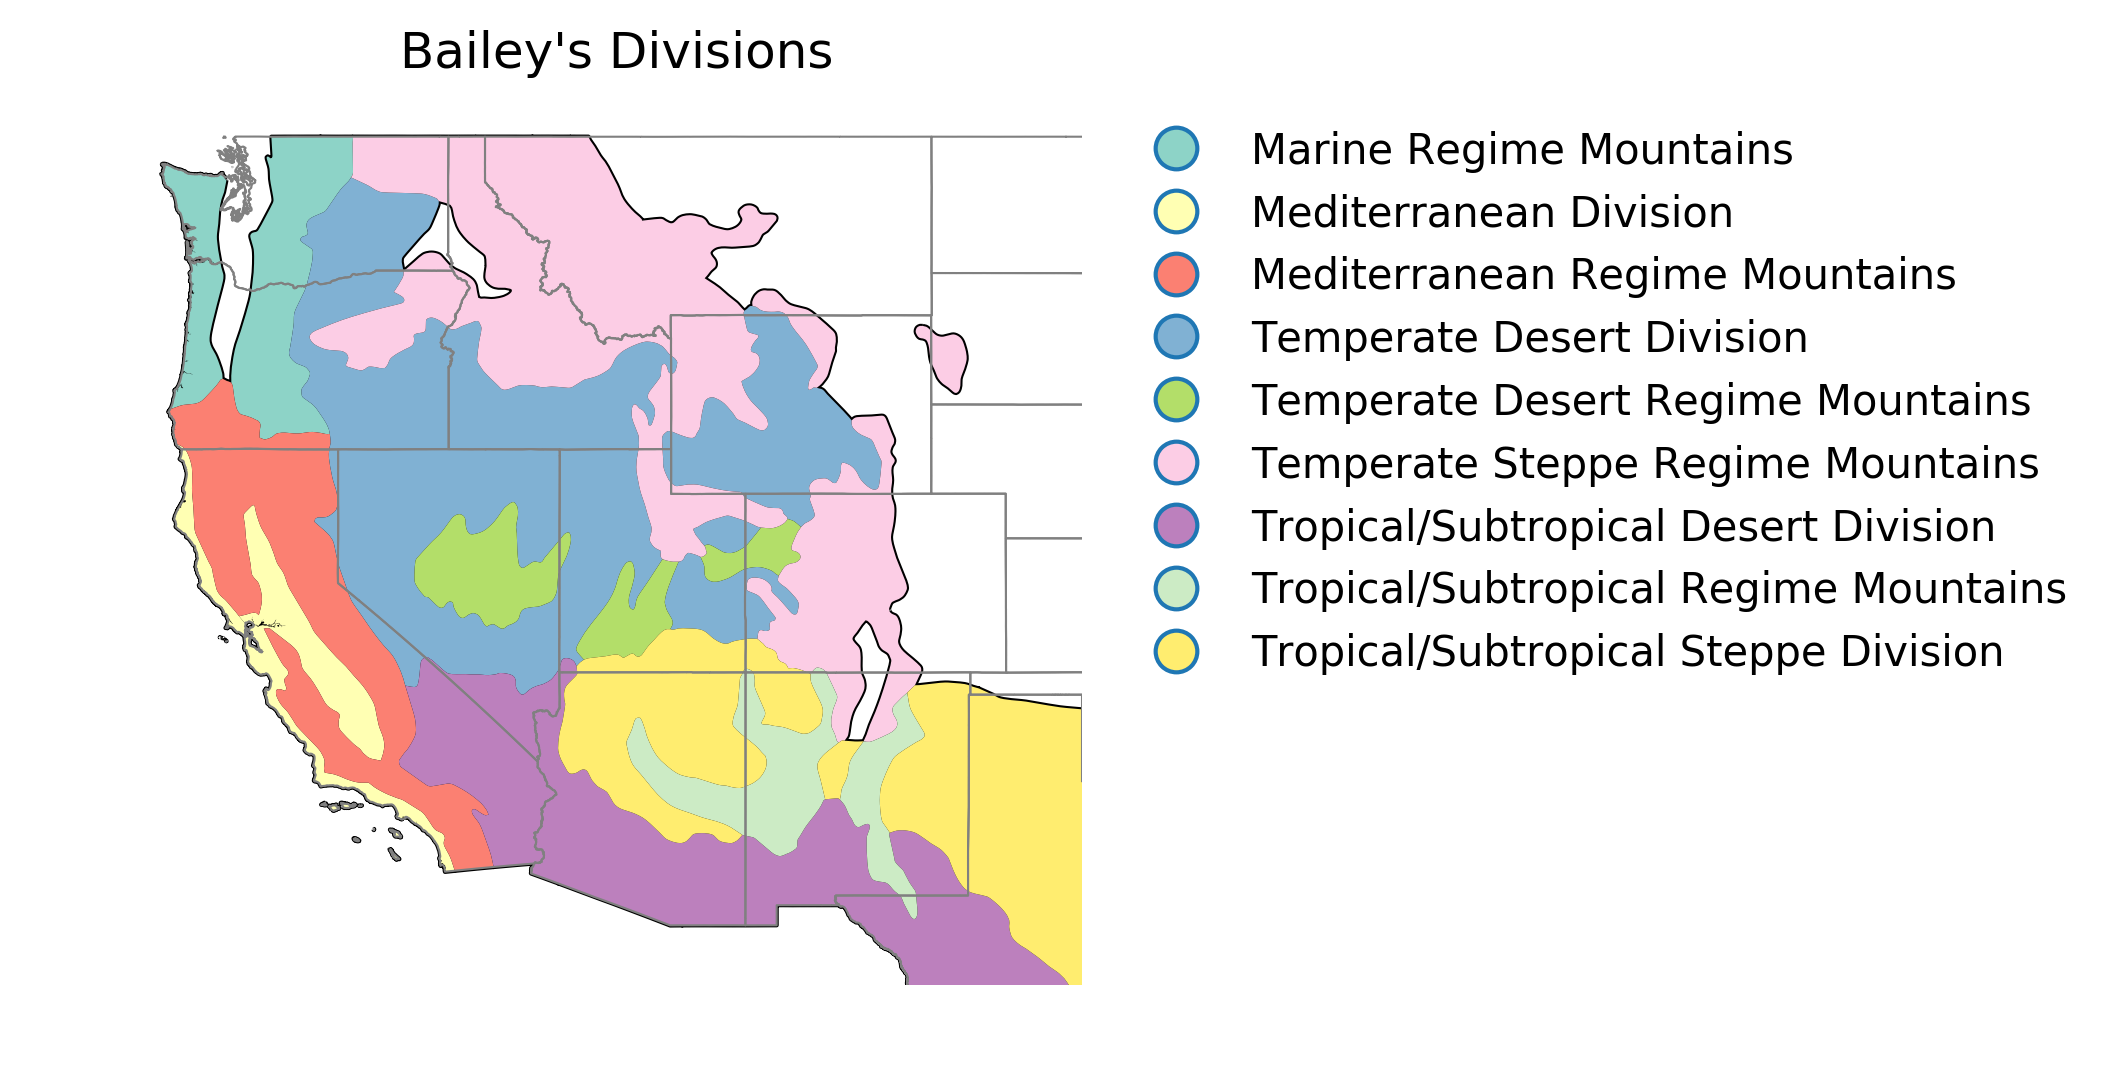

In [7]:
# Show the disolved divisions 
f, ax = plt.subplots(1, figsize=(4, 4), dpi=300)
ax.axis('off')

#base = usa.plot(ax=ax, color="white", edgecolor="black")
base = divisions.plot(ax=ax, color="white", edgecolor="black")
ax1 = divisions.plot(ax=base, column='division', cmap=tab10, categorical=True,legend=True)
ax1.set_xlim(left=-125, right=-100)
ax1.set_ylim(bottom=30, top=50)
plt.title("Bailey's Divisions")

ax2=usa.plot(ax=base, facecolor='none', edgecolor="gray", linewidth=0.5)
ax2.set_xlim(left=-125, right=-100)
ax2.set_ylim(bottom=30, top=50)
ax2.set_aspect(1.2)

# Handle the legend
leg = ax1.get_legend()
leg.set_bbox_to_anchor((0.6, 1, 1.5, 0.0))
leg.set_label(divisions.division)
leg.set_frame_on(False)

plt.savefig(fname=os.path.join(dataDir, "divinsions_map.png"), format='png', bbox_inches="tight")
plt.show()

### Setup consistent colors for divisions through paper 

In [8]:
div_color_dict = {}
COUNTER = 0
for div in divisions.division.values :
    div_color_dict[div] = division_colors_hex[COUNTER]
    COUNTER+=1

### Show the variance explained by each of the linear models
- Not to be shown in paper, but important for back-end analysis purposes. 

# Figure 2
### Show only atmos- and plant-centric

The max R-squared value is 0.601177 


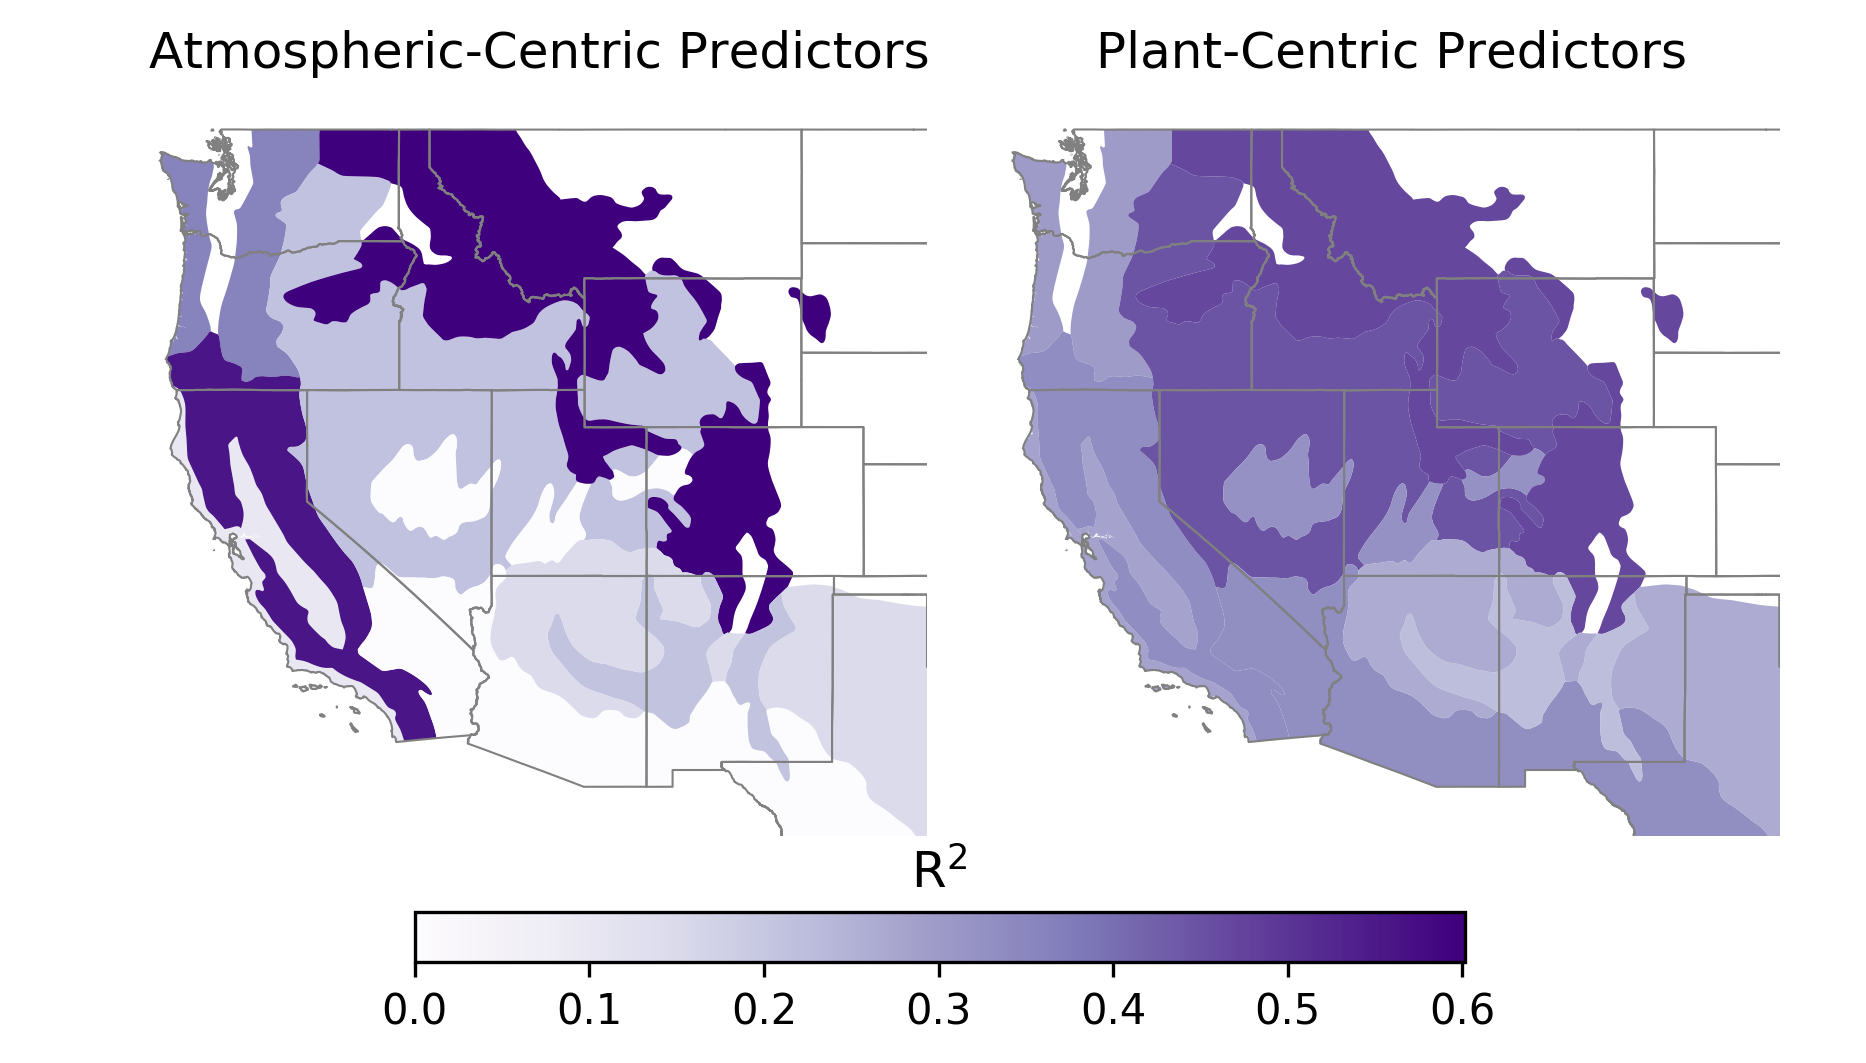

In [9]:
# Figure properties
asp=1.2
cm = "Purples"
max_r_squared = np.max((divisions["atmos_r2"], divisions["plant_r2"]) )
print("The max R-squared value is %f " % max_r_squared)
fig, (ax1, ax2) = pyplot.subplots(ncols=2, sharex=True, sharey=True, figsize=(7, 3.3), dpi=300)
ax1.axis('off')
ax2.axis('off')

#fig.suptitle('1984-2016 Burn Area Variance Explained')

divisions.plot(ax=ax1, column='atmos_r2', vmin=0, vmax=max_r_squared, legend=False, cmap=cm)
usa.plot(ax=ax1, facecolor='none', edgecolor="gray", linewidth=0.5)
ax1.set_xlim(left=-125, right=-100)
ax1.set_ylim(bottom=30, top=50)
ax1.set_title("Atmospheric-Centric Predictors")
ax1.set_aspect(asp)


divisions.plot(ax=ax2, column='plant_r2', vmin=0, vmax=max_r_squared, legend=False, cmap=cm)
usa.plot(ax=ax2, facecolor='none', edgecolor="gray", linewidth=0.5)
ax2.set_xlim(left=-125, right=-100)
ax2.set_ylim(bottom=30, top=50)
ax2.set_title("Plant-Centric Predictors")
ax2.set_aspect(asp)

plt.subplots_adjust(wspace=0.1, hspace=0) # reduce spaces between panes

im = plt.gca().get_children()[0]
# [left, bottom, width, height]
# for horizontal bar
cax = fig.add_axes([0.25, 0, 0.5,0.05]) 
fig.colorbar(im, cax=cax, orientation="horizontal")
plt.title("R$^{2}$")
#cax = fig.add_axes([0.25, .2, 0.03, 0.4]) 
#fig.colorbar(im, cax=cax, orientation="vertical")
plt.savefig(os.path.join(dataDir, "plant_v_atmos_variance_explained_map.png"), bbox_inches="tight")
plt.show()

Create a matrix of coefs from the predicts and Lasso. Use built in functions rather than for loops

In [10]:
lasso_all_coefs   = pd.read_csv(os.path.join(dataDir, 'lasso_all_coefs.csv'), index_col=0)
lasso_plant_coefs = pd.read_csv(os.path.join(dataDir, 'lasso_plant_coefs.csv'), index_col=0)
lasso_atmos_coefs = pd.read_csv(os.path.join(dataDir,'lasso_atmos_coefs.csv'), index_col=0)
lasso_combined_coefs = pd.read_csv(os.path.join(dataDir,'lasso_combined_coefs.csv'), index_col=0)

Remove all columns where every coef is zero. Those are variables we do not need to plot. 

In [11]:
def rm_zero_column(df) :
    """Remove any column where the sum is zero"""
    df_ = df.iloc[:, np.array(df.sum() != 0)]
    # Set -0 to zero
    return df_.where(df_!=0, 0)

In [12]:
lasso_all_coefs   = rm_zero_column(lasso_all_coefs)
lasso_plant_coefs = rm_zero_column(lasso_plant_coefs)
lasso_atmos_coefs = rm_zero_column(lasso_atmos_coefs)
lasso_combined_coefs = rm_zero_column(lasso_combined_coefs)

### Show the coefs when ALL variables where given to the Lasso at once. 

### Is it more meaningful to show this in terms of -max:max scale for each ecoregion so that local importance and sign of relationship is what is shown? 

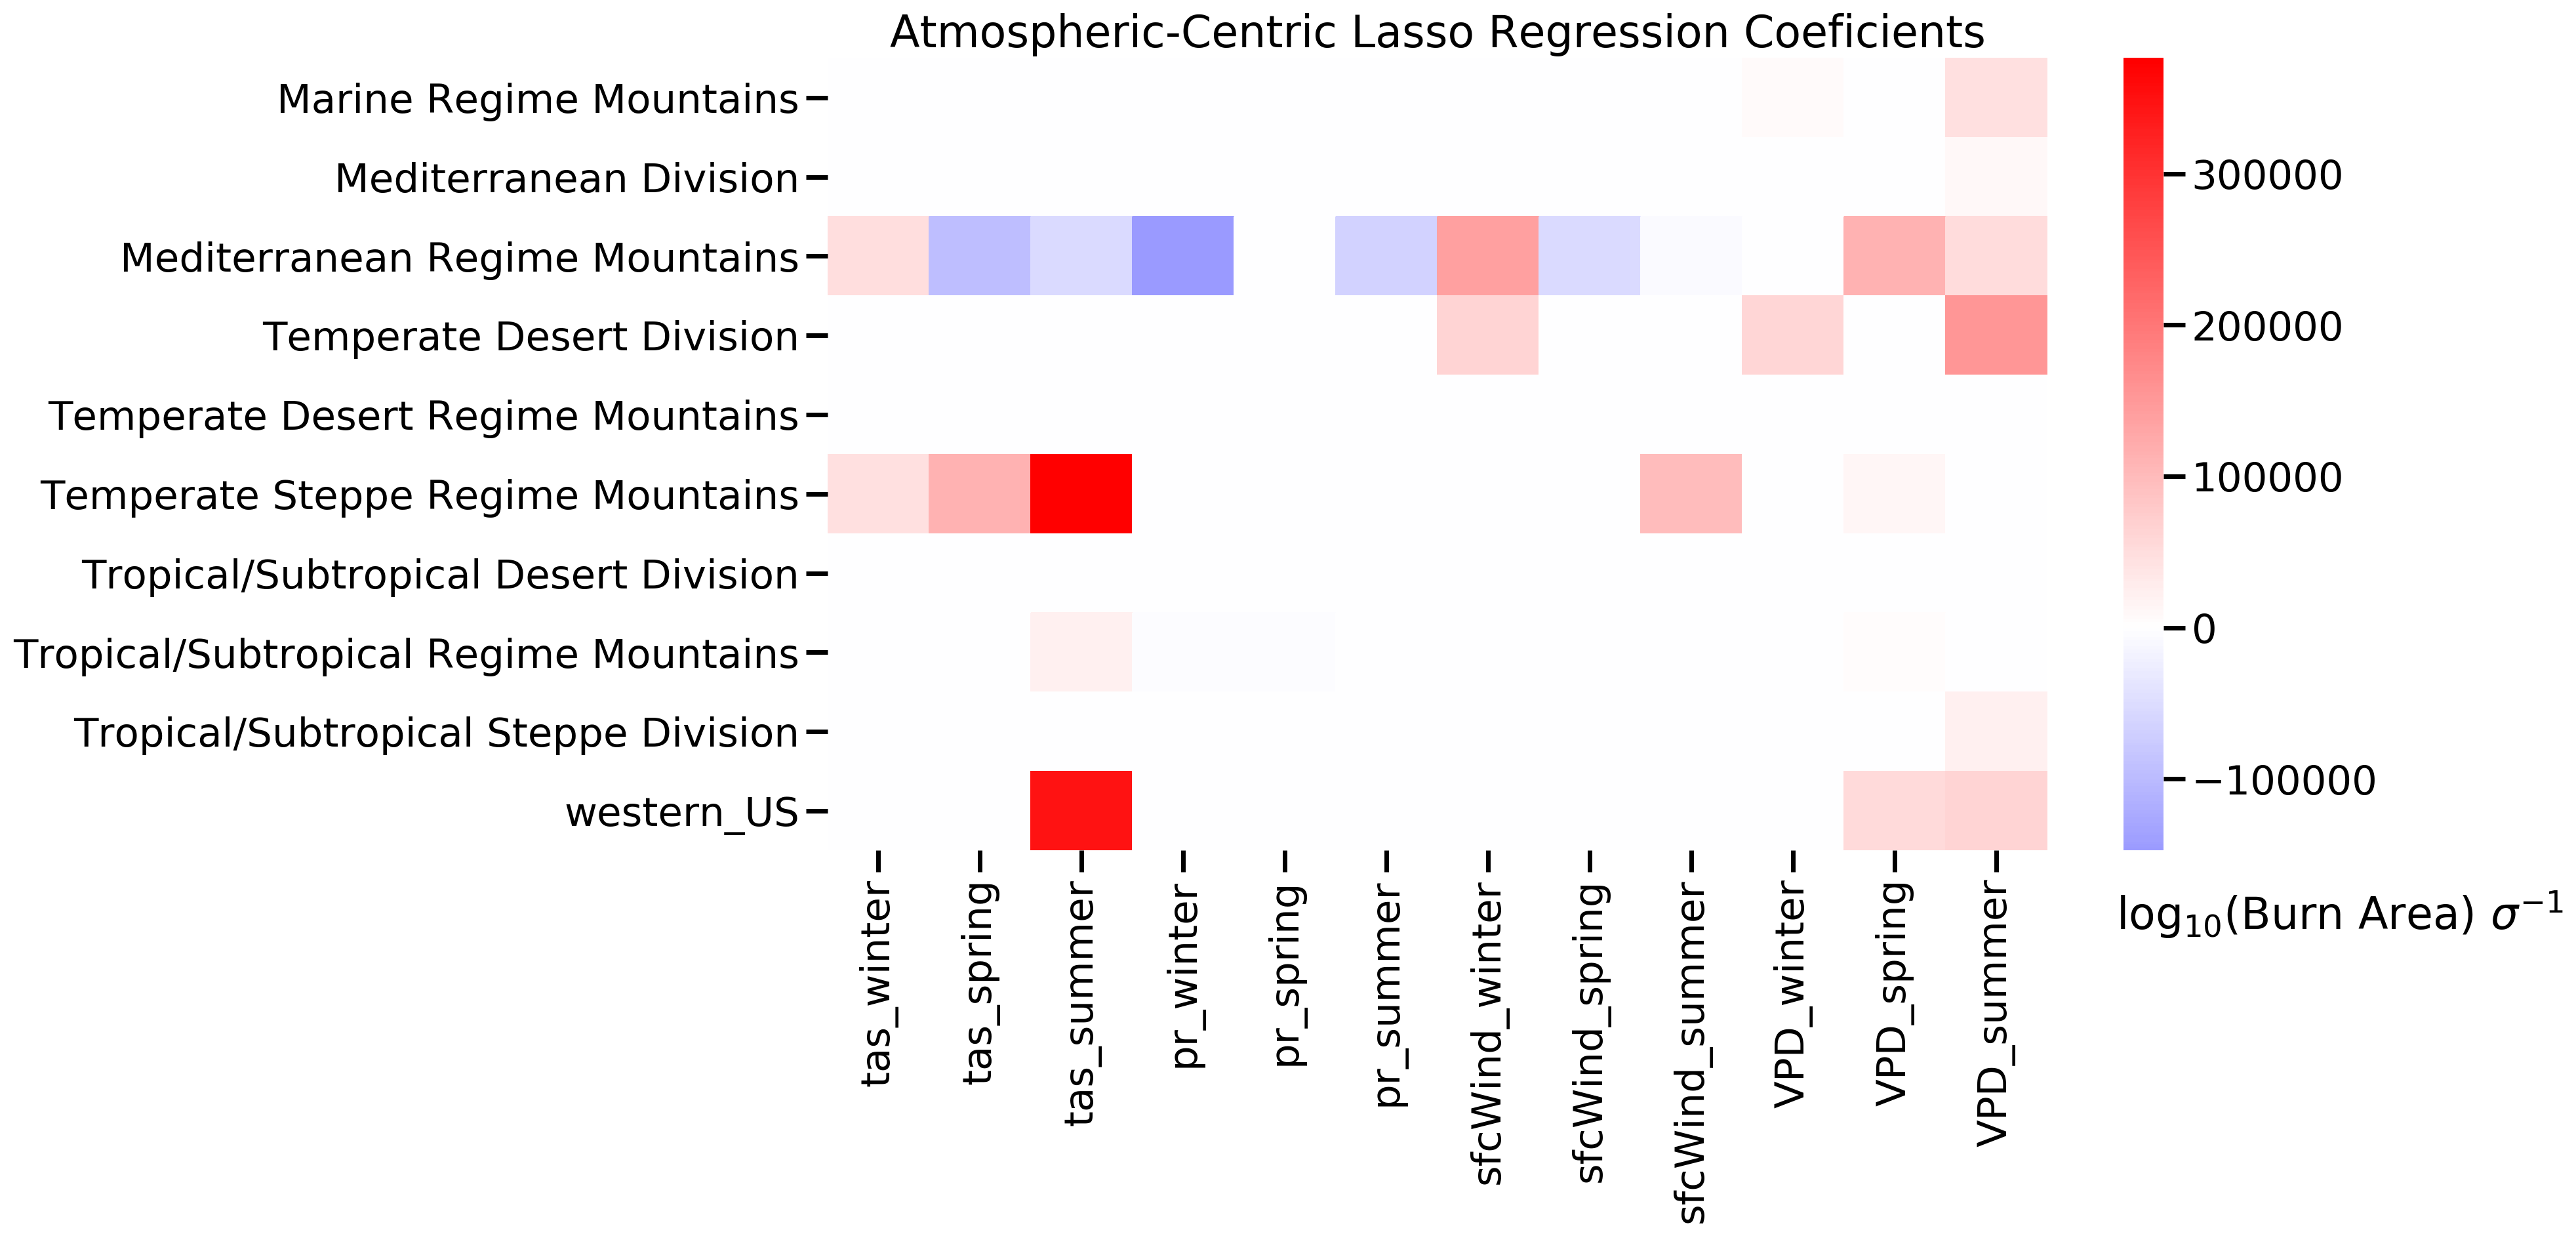

In [13]:
with sns.plotting_context("poster") :
    # TODO: Show r-squared on this plot 
    f, ax = plt.subplots(figsize=(15, 8), dpi=200)
    ax1 = sns.heatmap(lasso_atmos_coefs, center=0, cmap="bwr")
    ax1.set(xlabel="", ylabel="", title="Atmospheric-Centric Lasso Regression Coeficients")
    f.text(x=0.78, y=.05, s="log$_{10}$(Burn Area) $\sigma^{-1}$")
    plt.savefig(os.path.join(dataDir, "lasso_atmos_coefs_heat_matrix.png"), bbox_inches='tight')
    plt.show()

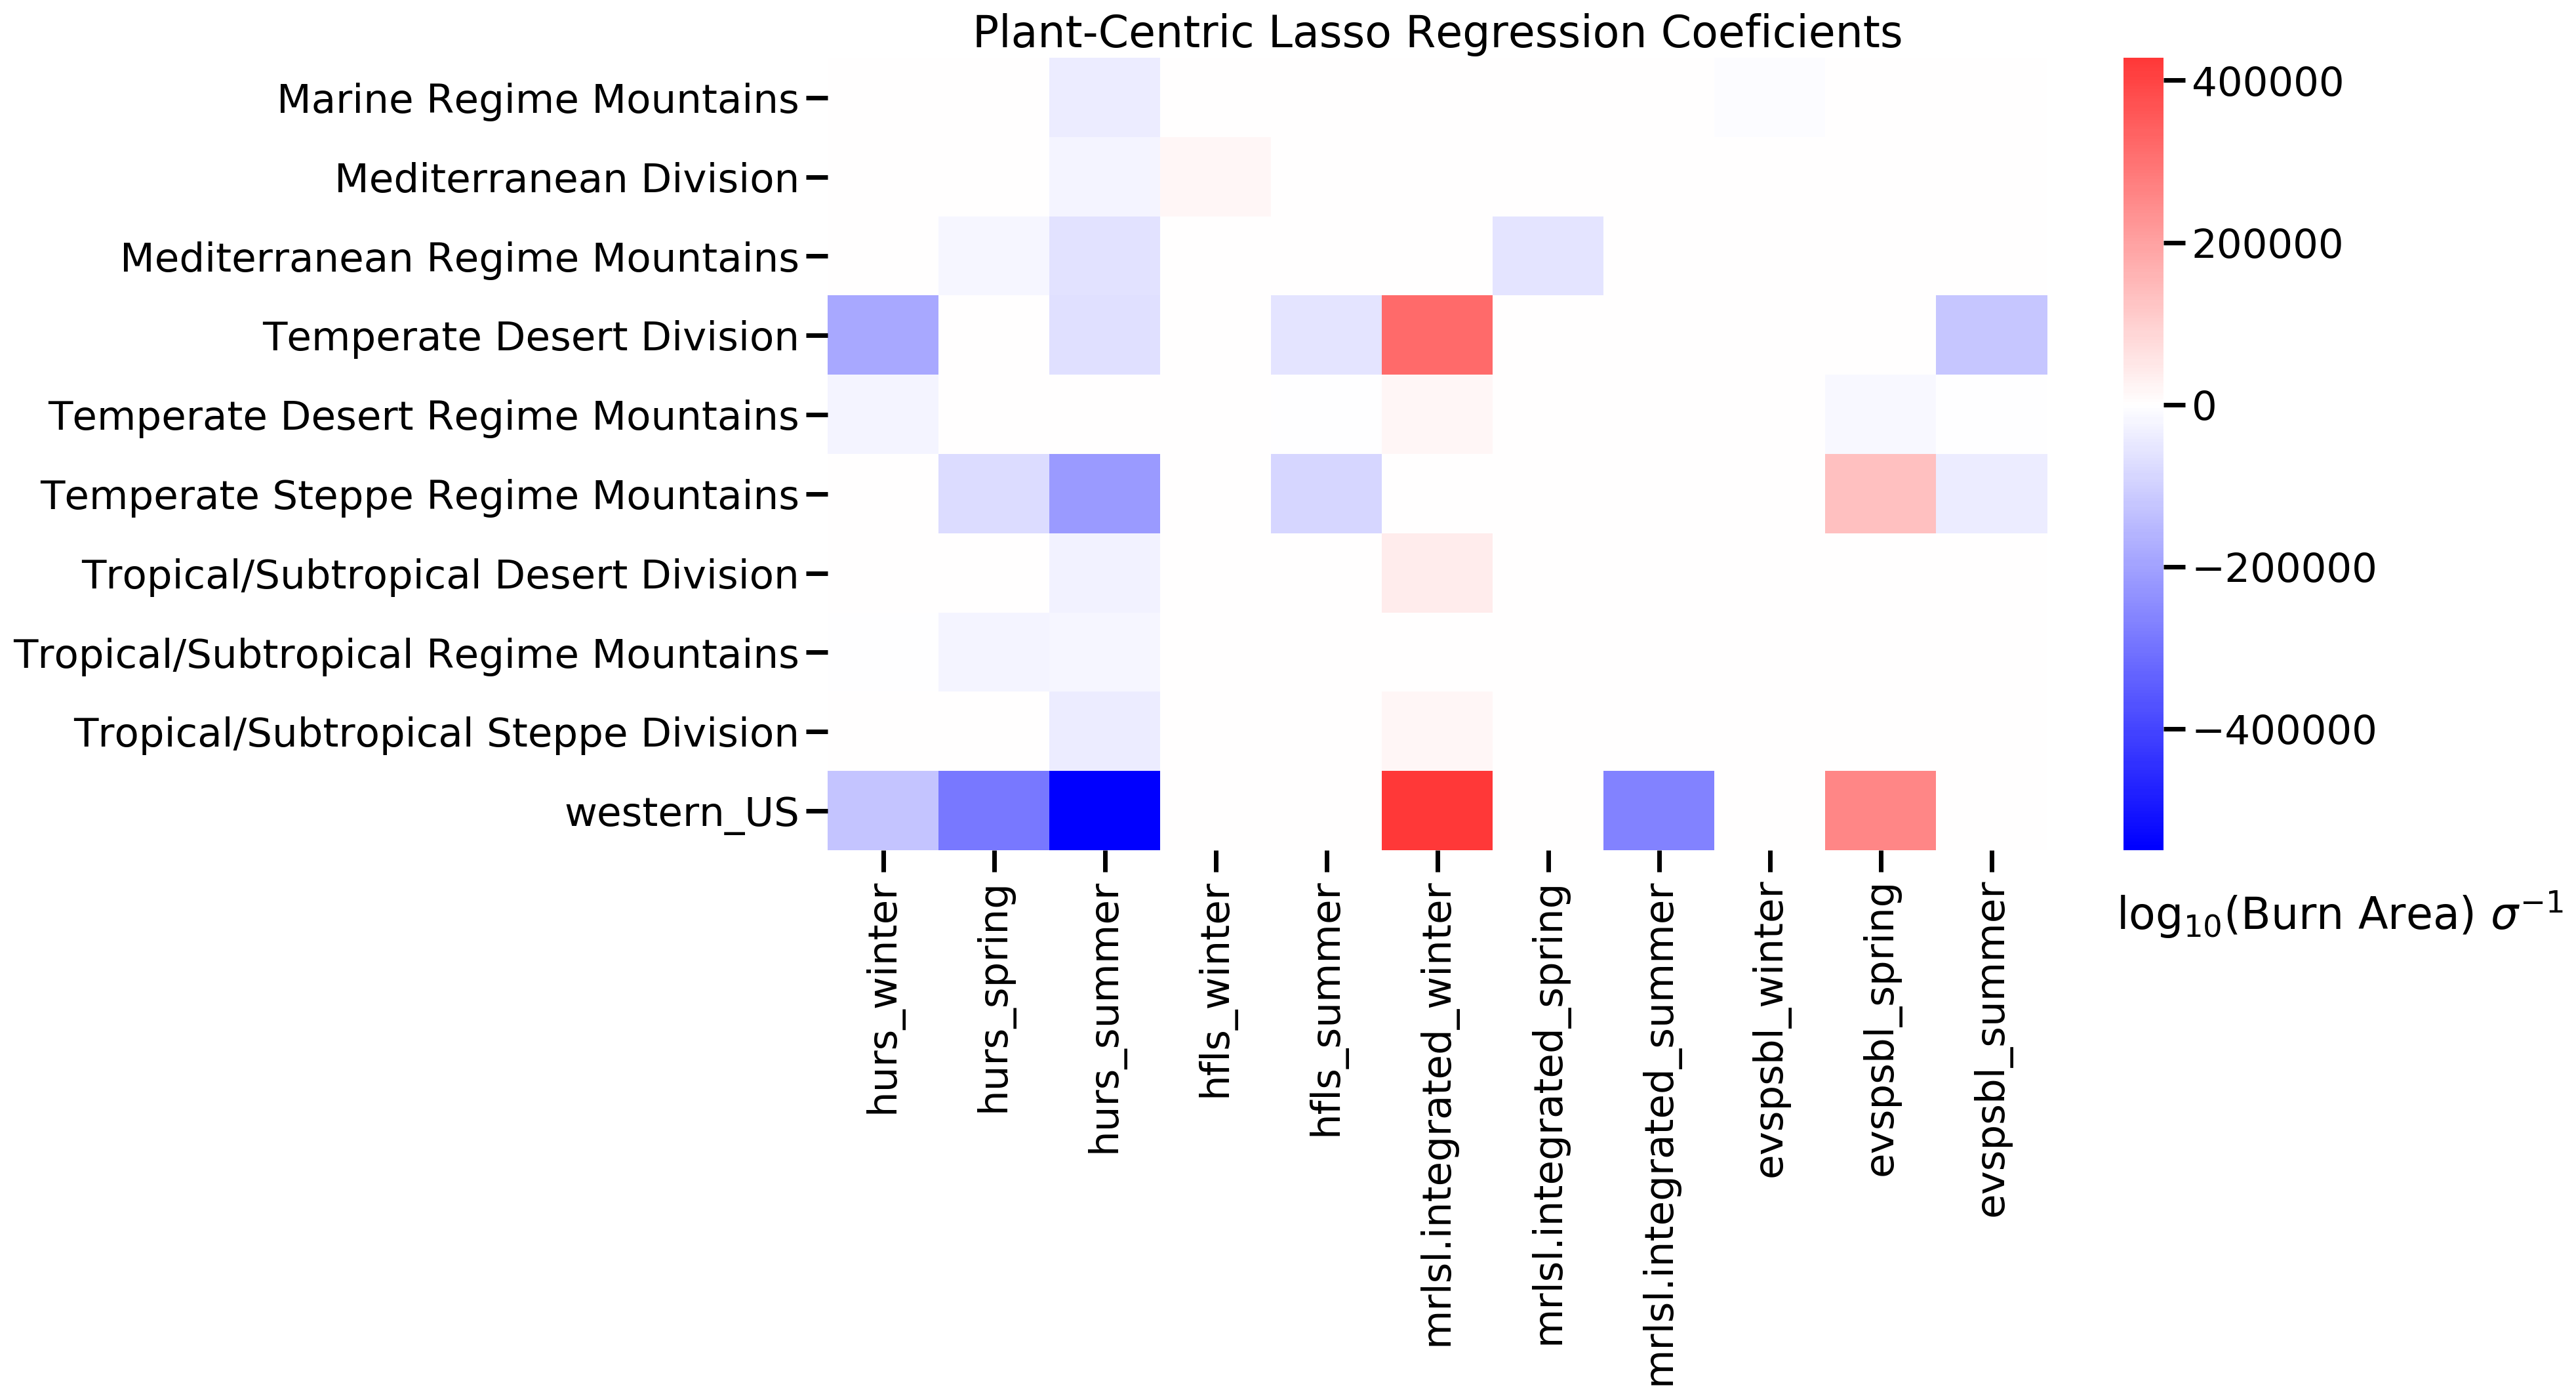

In [14]:
with sns.plotting_context("poster") :
    # TODO: Show r-squared on this plot 
    f, ax = plt.subplots(figsize=(15, 8), dpi=200)
    ax1 = sns.heatmap(lasso_plant_coefs, center=0, cmap="bwr")
    ax1.set(xlabel="", ylabel="", title="Plant-Centric Lasso Regression Coeficients")
    f.text(x=0.78, y=.05, s="log$_{10}$(Burn Area) $\sigma^{-1}$")
    plt.savefig(os.path.join(dataDir, "lasso_plant_coefs_heat_matrix.png"), bbox_inches='tight')
    plt.show()

## Figure 3 in paper 

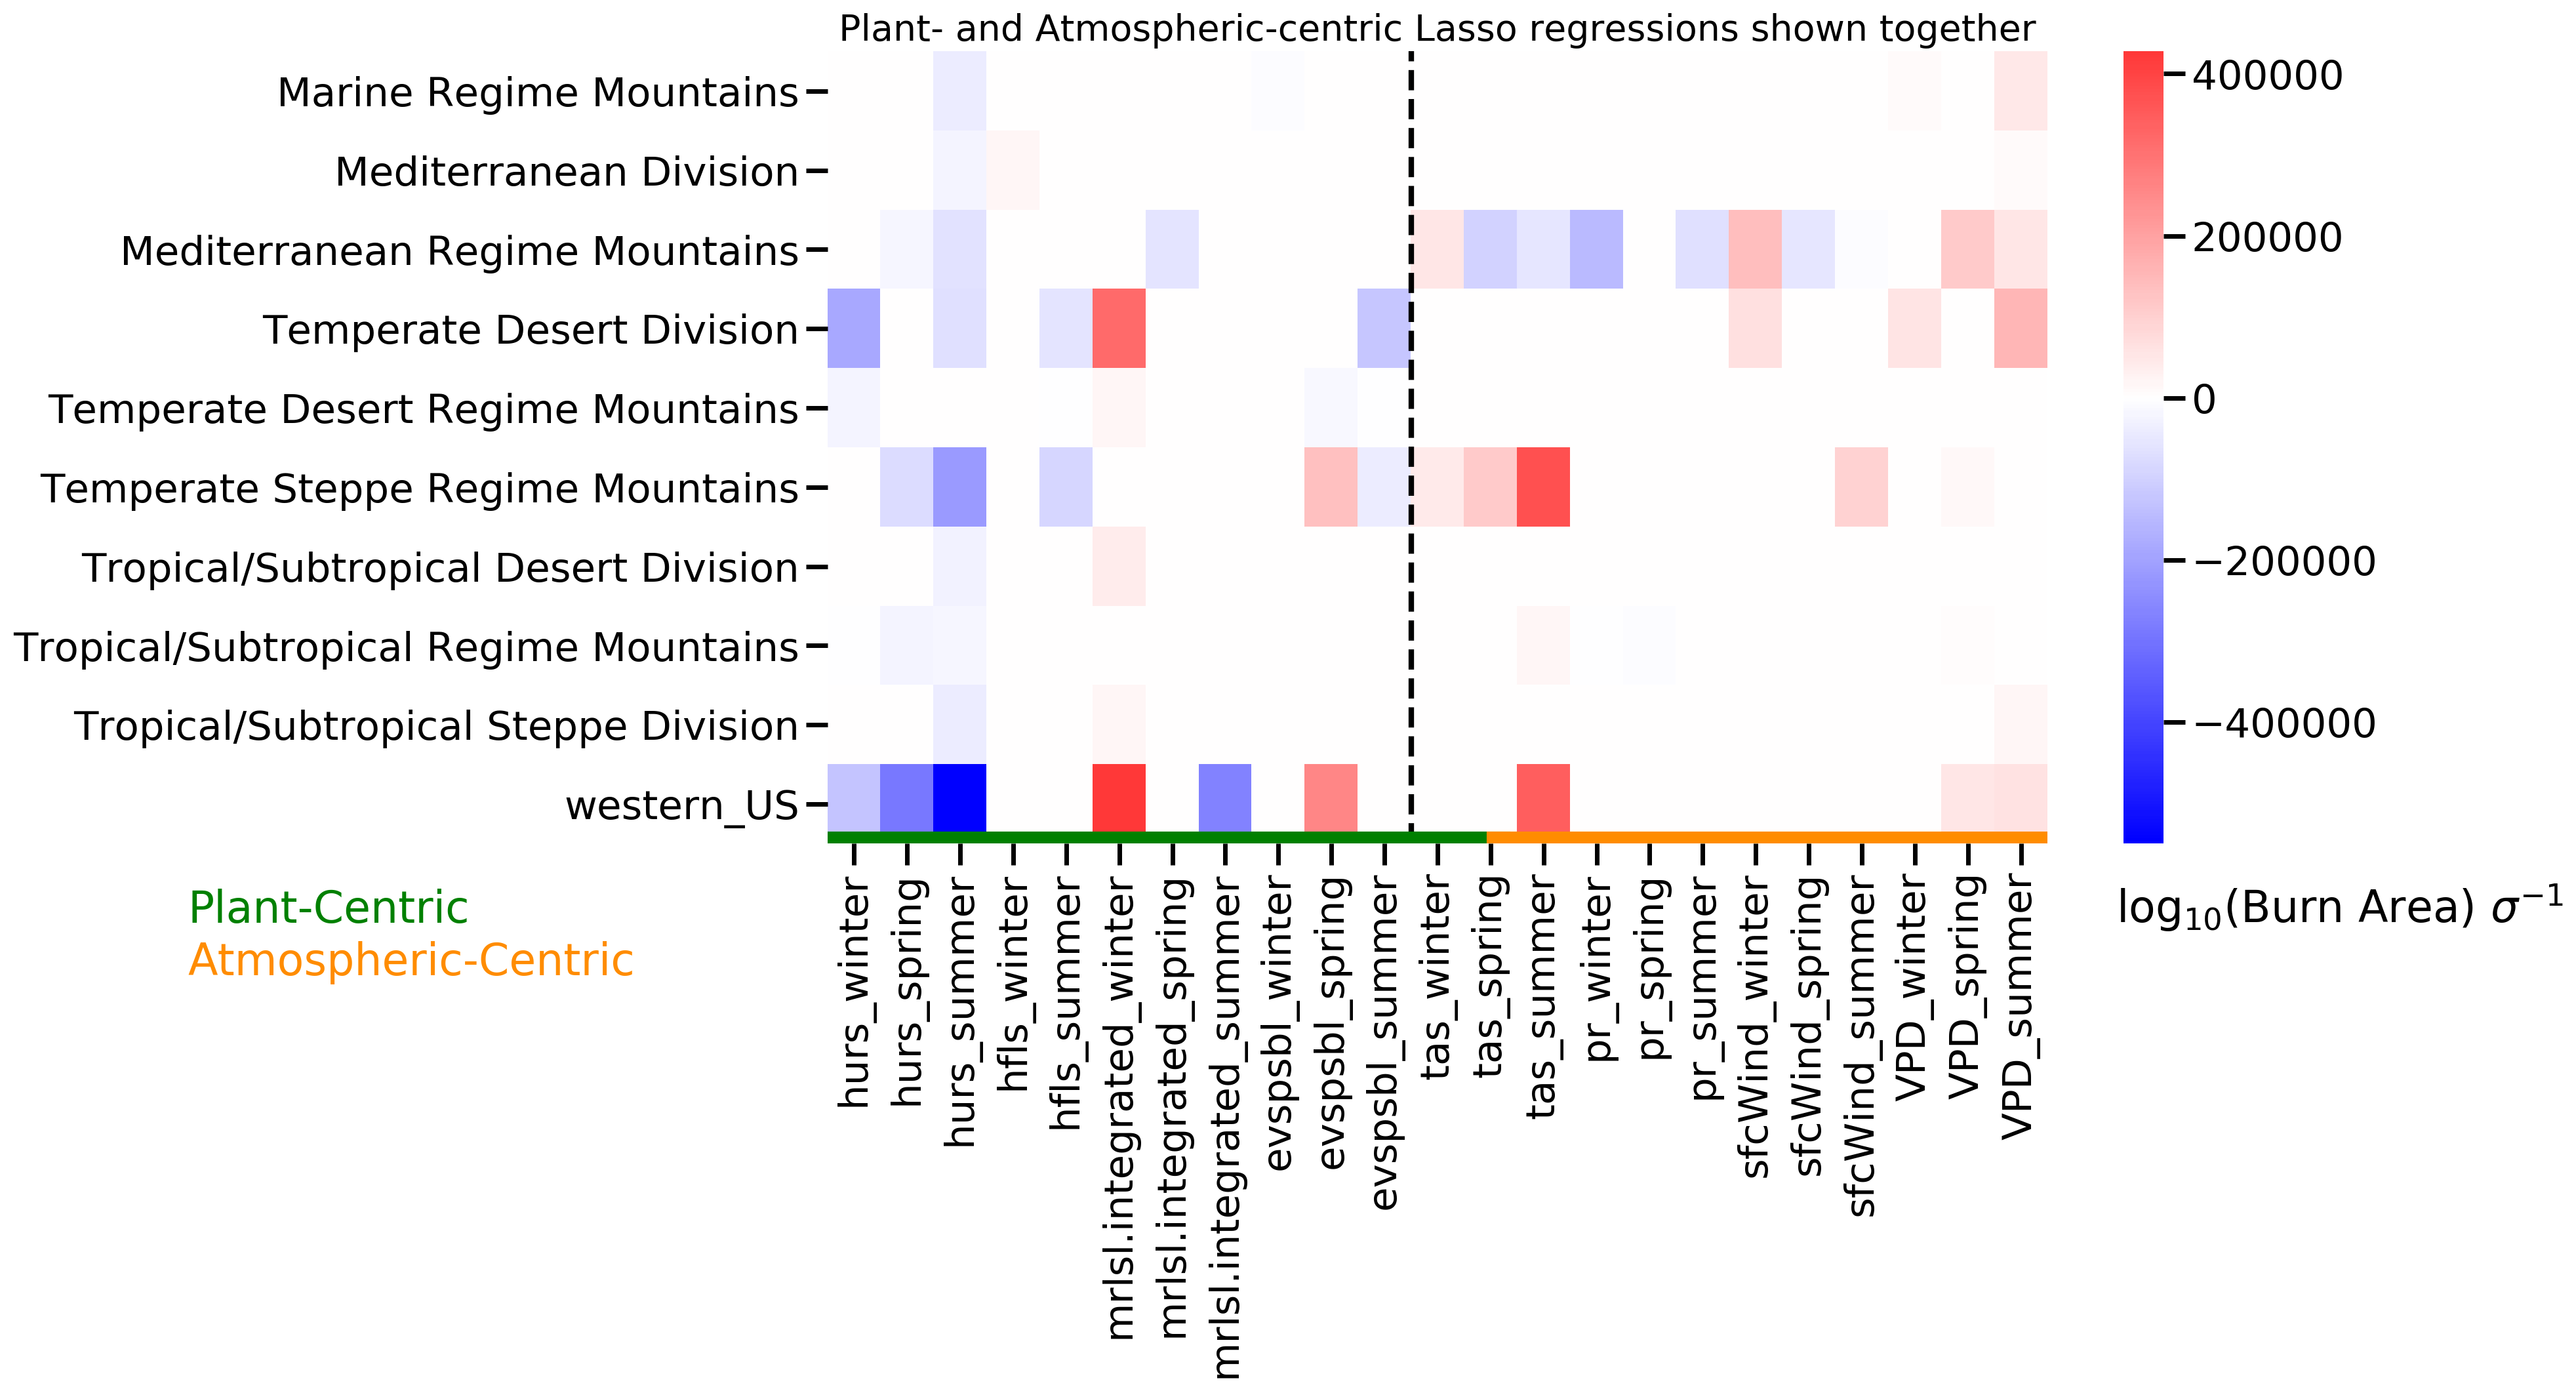

In [15]:
with sns.plotting_context("poster") :
    # TODO: Show r-squared on this plot 
    f, ax = plt.subplots(figsize=(15, 8), dpi=200)
    ax1 = sns.heatmap(lasso_combined_coefs, center=0, cmap="bwr")
    
    #ax1.set_xticklabels(labels=lasso_combined_coefs.columns , rotation=30)
    
    ax1.set(xlabel="", ylabel="")
    ax1.axes.set_title("Plant- and Atmospheric-centric Lasso regressions shown together",fontsize=20)
    f.text(x=0.78, y=.05, s="log$_{10}$(Burn Area) $\sigma^{-1}$")
    
    ax1.axvline(x=11., linewidth=3, color="k", linestyle="--")
    ax1.axhline(y=10, xmin=0, xmax=11/20., color="green", linewidth=13)
    ax1.axhline(y=10, xmin=11/20., xmax=1., c="darkorange", linewidth=13)
    
    f.text(x=-0.2, y=.05, s="Plant-Centric", color="green")
    f.text(x=-0.2, y=.00, s="Atmospheric-Centric", color="darkorange")
    
    plt.savefig(os.path.join(dataDir, "lasso_combined_coefs_heat_matrix.png"), bbox_inches='tight')
    plt.show()

In [16]:
R2_df = pd.DataFrame(divisions[["OLS_r2","lasso_r2", "atmos_r2", "plant_r2"]])
R2_df.rename(columns={"OLS_r2":"OLS", 
                      "lasso_r2":"Lasso All",
                      "atmos_r2":"Lasso Atmospheric",
                      "plant_r2":"Lasso Plant"}, 
                      inplace=True)
R2_df

OLS  Lasso All  Lasso Atmospheric  \
division                                                                        
Marine Regime Mountains                0.808422   0.294944           0.357579   
Mediterranean Division                 0.731524   0.195353           0.097607   
Mediterranean Regime Mountains         0.893900   0.296793           0.560904   
Temperate Desert Division              0.961846   0.417176           0.212377   
Temperate Desert Regime Mountains      0.819289   0.000000           0.000000   
Temperate Steppe Regime Mountains      0.919294   0.503346           0.601177   
Tropical/Subtropical Desert Division   0.904864   0.203953           0.000000   
Tropical/Subtropical Regime Mountains  0.945003   0.233432           0.209538   
Tropical/Subtropical Steppe Division   0.796041   0.140419           0.146181   

                                       Lasso Plant  
division                                            
Marine Regime Mountains                   0.299282  
Mediterranean Division                    0.282432  
Mediterranean Regime Mountains            0.335427  
Temperate Desert Division                 0.444536  
Temperate Desert Regime Mountains         0.322594  
Temperate Steppe Regime Mountains         0.468403  
Tropical/Subtropical Desert Division      0.331421  
Tropical/Subtropical Regime Mountains     0.225254  
Tropical/Subtropical Steppe Division      0.264917

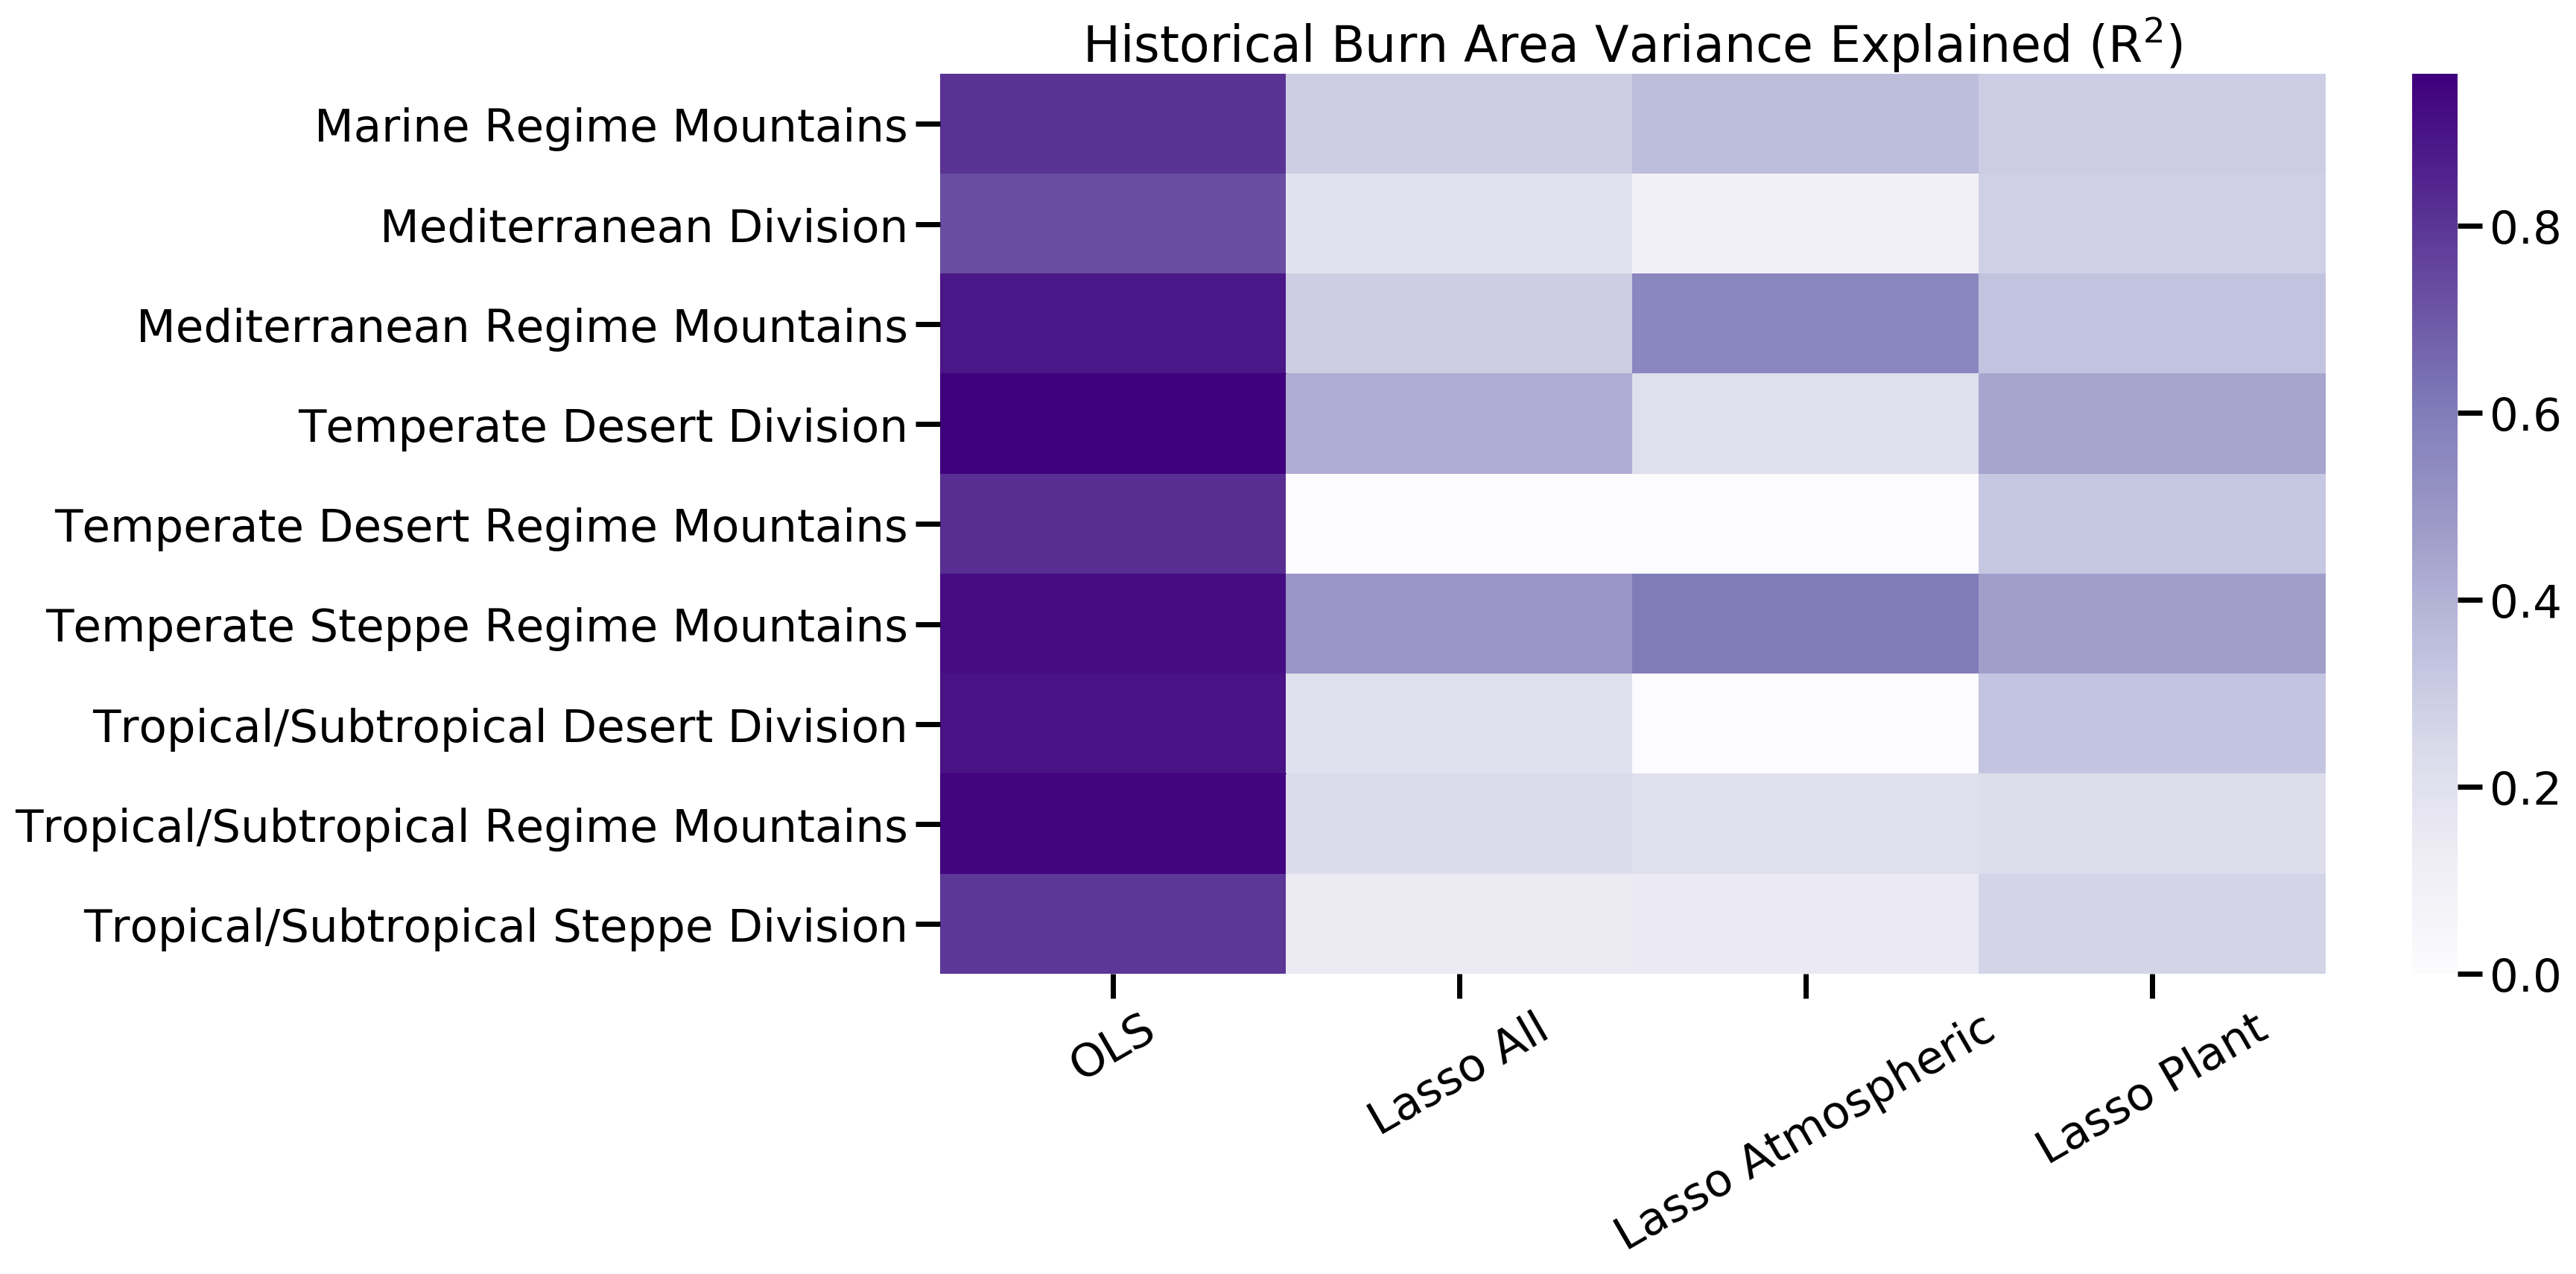

In [17]:
with sns.plotting_context("poster") :
    f, ax = plt.subplots(figsize=(15, 8), dpi=200)
    ax1 = sns.heatmap(R2_df, cmap="Purples")
    ax1.set(xlabel="", ylabel="", title="Historical Burn Area Variance Explained (R$^{2}$)")
    ax1.set_xticklabels(labels=R2_df.columns , rotation=30)
    #ax1.collections[0].colorbar.set_label("R$^{2}$")
    plt.savefig(os.path.join(dataDir,"models_variance_explained_heatmap.png"),  bbox_inches='tight')

Make all three of the above plots work together below. 

# Show predictor importance and variance
- NOTE: lasso_combined_coefs does not have columns in the same order as Z_dict of era-interim, so make sure that you account for that when reading data in function below. 

In [18]:
def get_cmip5_Z_dict(regression_name, rcp) :
    """
    Function for loading pickled CMIP5 dictionaries. Returns 
    dictionary associated with the specified file name. 
    """
    
    # Get the CMIP5 features expressed in terms of historical variance "Z_dict"
    # or their raw values averaged in a region ""
    f = regression_name + "_Z_cmip_" + rcp + '_dict.obj'
    print("Getting " + f)
    with open(os.path.join(dataDir, f), 'rb') as fp:
        Z_cmip_dict = pickle.load(fp)
    return Z_cmip_dict 

#### Setup a color dictionary for consistent colors for predictors 

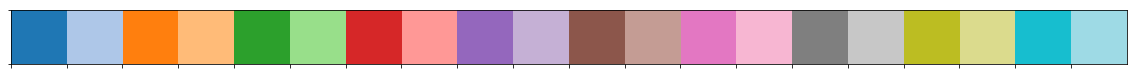

In [19]:
lasso_combined_coefs.shape[1]
sns.palplot(sns.color_palette("tab20"))

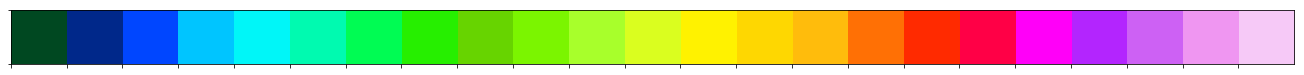

In [21]:
sns.palplot(sns.color_palette("gist_ncar", 23, 1))

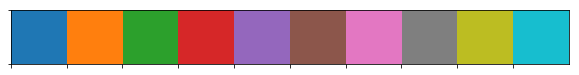

In [21]:
sns.palplot(sns.color_palette("tab10"))

### Make a custom legend and color scheme

In [22]:
# first, a color scheme, it adjusts when the number of unique colors changes  

print(lasso_combined_coefs.shape)

n_column_coef = lasso_combined_coefs.shape[1]
if n_column_coef > 20 :
    cols = sns.color_palette("gist_ncar", n_column_coef, 1)
else : 
    cols = sns.color_palette("tab20")
    
color_dict = {}
for i in range(n_column_coef) :
    color_dict[lasso_combined_coefs.columns.values[i]] = cols[i]
color_dict

(10, 23)


{'hurs_winter': (0.0, 0.28619761630142254, 0.13306497500961173),
 'hurs_spring': (0.0, 0.1596396228436728, 0.5435759503801522),
 'hurs_summer': (0.0, 0.2766442983467896, 1.0),
 'hfls_winter': (0.0, 0.7752259284890424, 1.0),
 'hfls_summer': (0.0, 0.9653681814686655, 0.9741483093237298),
 'mrlsl.integrated_winter': (0.0, 0.9839560165597562, 0.6913351840736296),
 'mrlsl.integrated_spring': (0.0, 0.9885719816437213, 0.3276351409833889),
 'mrlsl.integrated_summer': (0.14987017543859624, 0.940799477124183, 0.0),
 'evspsbl_winter': (0.407163321799308, 0.8337428842504745, 0.0),
 'evspsbl_spring': (0.48482575932333677, 0.9615101201771029, 0.0),
 'evspsbl_summer': (0.6610574466945252, 1.0, 0.17176072428971612),
 'tas_winter': (0.8573751723275834, 0.9999999999999999, 0.12482388288648794),
 'tas_spring': (1.0, 0.9517185042322938, 0.0),
 'tas_summer': (0.9999999999999999, 0.8453289903210824, 0.004213010380622939),
 'pr_winter': (1.0, 0.7389394764098716, 0.05064899653979249),
 'pr_spring': (1.0, 0.4

#### Create a custom legend 
- For consistent colors for a given feature 
- Consistent shape for feature type (plant, atmos)

In [23]:
feature_legend = [] # empty list

# e.g.
# Green dot: Line2D([0], [0], marker='o', color='w', label='plant', markerfacecolor='g', markersize=15),
# Green square: Line2D([0], [0], marker='s', color='w', label='atmos', markerfacecolor='g', markersize=15),
for feature in color_dict.keys() : 
    #print(feature)
    if pd.Series(feature).isin(lasso_plant_coefs.columns)[0] : 
        marker = "o" # Plant marker
    else : 
        marker = "s" # Atmos marker

    fc = color_dict[feature]

    # Set feature attributes to Line2D
    line_feature = Line2D([0], [0], marker=marker, color='w', label=feature, markerfacecolor=fc, markersize=15)
    # Store in list 
    feature_legend.append(line_feature)


In [24]:
def create_scatter_df(div, coef_df, div_Z_dict, y1=2070, y2=2099) :  
    """
    This creates a dataframe that makes for easy plotting and handling of differences
    in feature values from the training period 1984-2016 to years y1:y2. By the definition
    of how we standardize CMIP5 data for, the mean value for all CMIP model feature values
    for 1984-2016 the same as ERA-Interim, thus the difference is zero. The dataframe created
    
    Parameters
    ----------
        div : str, the division (ecoregion) for which a scatter_df will be created. 
        coef_df : pd.DataFrame, of lasso regression coeficients with shape =(n_division, n_features) 
        div_Z_dict : {}, containing different divisions dictionary of CMIP5 model Z (standardized)
                     output for estimating the change. 
        y1 : int, first year of the time period to average. 
        y2 : int, last year of the time period to average. 
        
    """
        
    # Get the division coeficients, only where non-zero, for this division. 
    df = coef_df.loc[div, coef_df.loc[div] != 0 ].copy()

    # Set up the DataFrame to hold information for scatterploting for div
    col_names = ["division", "feature", "feature_N", "feature_type", "coef", 
                 "CMIP5_mean", "CMIP5_std","CMIP5_min", "CMIP5_max"]
    
    df_scatter = pd.DataFrame(index=df.index, columns=col_names)
    df_scatter["division"]  = div
    df_scatter["feature_N"] = len(div_Z_dict.keys()) # models with all features for division 
    df_scatter["feature"]   = df_scatter.index.values.copy()
    df_scatter["coef"]      = df.values.copy()

    for model in div_Z_dict.keys() : 

        # Assign CMIP5 stats where they belong here. 
        Z_cmip = div_Z_dict[model]

        # We want the values for the last 30 years of 21st century
        # TODO: make time period a variable 
        future_mean_sigma = Z_cmip.loc[y1:y2, :].mean() # mean of columns, here variables 

        # Get the future sigma for the variables with non-zero coefs 
        # Add the new column for the data from THIS model 
        df_scatter[model] = future_mean_sigma[df_scatter.index]
            
    # Get the stats on the rows from the model sigma output. This gives the
    # mean of the changes calculated in the for loop above. 
    model_columns = list(div_Z_dict.keys())
    df_scatter.loc[:, "CMIP5_mean"] = df_scatter[model_columns].mean(axis=1).copy()
    df_scatter.loc[:, "CMIP5_std"] = df_scatter[model_columns].std(axis=1).copy()
    df_scatter.loc[:, "CMIP5_min"] = df_scatter[model_columns].min(axis=1).copy()
    df_scatter.loc[:, "CMIP5_max"] = df_scatter[model_columns].max(axis=1).copy()
    
    # Assign feature types
    # TODO: Pass these in
    plant_vars = ['mrlsl.integrated', 'evspsbl', 'hurs', 'hfls'] 
    atmos_vars = ['tas', 'VPD', 'pr', 'sfcWind']       
    
    for i in df_scatter["feature"] : 
        #print(i)
        s = pd.Series(i.split("_")[0]).isin(plant_vars).values
        #print(s)
        if  s : 
            df_scatter.loc[i, "feature_type"] = "Plant-Centric"
        else :
            df_scatter.loc[i, "feature_type"] = "Atmos-Centric"
            
    return df_scatter 

TODO: Remake this figure, capable of showing RCP 4.5 and 8.5 together

In [25]:
def plot_coef_vs_std(div, dataDir, regression_name, df, return_fig=False, rcp="8.5", color_dict='none', y1=2070, y2=2099) :  

    """
    TODO: Description + notes
    """
    
    figure_savename = os.path.join(dataDir, regression_name + "_" + div.replace("/", " ") + "_coefs_vs_rcp"+rcp.replace(".","")+"_std.png")
    title_text = "RCP" +rcp +" CMIP5 $\mu_{"+str(y1)+"-"+str(y2)+"}$ - ERA-Interim $\mu_{1984-2016}$"    
    
    marker_dictionary = {"Plant-Centric":"o",
                         "Atmos-Centric":"s"
                        }
    
    if issubclass(type(color_dict), str) : 
        # No dictionar of colors passed, use defualt cmap
        pal = sns.color_palette("gist_ncar", df.shape[0], 1)
    else : 
        pal = color_dict
    
    ############################
    # Data ready, begin plotting 
    ############################
    if not return_fig :
        fig = plt.figure(dpi=250, figsize=(4, 4))
            
    ax = sns.scatterplot(x="coef", y="CMIP5_mean", hue="feature",
                         style="feature_type", data=df, 
                         markers=marker_dictionary, s=70,
                         palette=pal, edgecolors="k", zorder=4)
    
    #ax.axis('off')
    #ax.axhline(y=1, color="gray", linestyle="--", linewidth=0.5)
    ax.axhline(y=0, color="k", linestyle="--", linewidth=0.8)
    #ax.axhline(y=-1, color="gray", linestyle="--", linewidth=0.5)

    ax.axvline(x=0, color="k", linestyle="--", linewidth=0.8)
    #ax.vlines(x=0, ymin=ymin, ymax=ymax, linestyle="--", color="k", linewidth=0.8)

    ax.set(xlabel='Regression Coefficient [log$_{10}$(Burn Area) $\sigma^{-1}$]', 
           ylabel='$\Delta$  [ERA-Interim$\sigma$$_{1984-2016}$]')
    
    if not return_fig :
        ax.legend( bbox_to_anchor=(1,1.), title="", frameon=False)
        plt.title(label=title_text, fontsize=9)
        plt.suptitle(div)
    else :
        plt.title(label=div + " RCP" + rcp, fontsize=12)
        # remove spines for neat plots. 
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
    
    # Calculate the error (spread extent) bars for each variable
    error = np.zeros(shape=(2, len(df['CMIP5_min'])))
    lower_ext = df["CMIP5_mean"] - df['CMIP5_min']  # how far below 
    upper_ext = df['CMIP5_max'] - df["CMIP5_mean"]  # how far above 
    error[0][:] = np.array(lower_ext)
    error[1][:] = np.array(upper_ext)
    
    ax.errorbar(df["coef"], df["CMIP5_mean"], fmt=' ', 
                yerr=error, capsize=2, linewidth=0.8, 
                color="k", zorder=2)
    
    ################################################################
    # Add background color shading
    #ymin, ymax = ax.get_ylim()
    #xmin, xmax = ax.get_xlim()

    #plt.vlines(x=0, ymin=ymin, ymax=ymax, linestyle="--", color="k")
    #plt.axhline(y=0, linestyle="--", color="k")
    #plt.fill([0,xmax,xmax,0], [0,0,ymax,ymax], 'b', alpha=0.2, edgecolor='r', zorder=0)


    
    # TODO: consider adding Standard dev
    #error = np.zeros(shape=(2, len(df['CMIP5_min'])))
    #lower_ext = df["CMIP5_mean"] - df['CMIP5_std']  # how far below 
    #upper_ext = df['CMIP5_std'] - df["CMIP5_mean"]  # how far above 
    #error[0][:] = np.array(lower_ext)
    #error[1][:] = np.array(upper_ext)
    #ax.errorbar(df["coef"], df["CMIP5_mean"], fmt=' ', 
    #            yerr=error, capsize=2, linewidth=0.8)
    
    if not return_fig : 
        plt.savefig(figure_savename, bbox_inches='tight')
        plt.close()
    else :
        return ax
    

### plot_coef_vs_std() for lasso_all regressions

### plot_coef_vs_std() for lasso_combined regressions by merging plant and atmos
#### - TODO: Make this multipanel with a shared y or x axis for the regions of interest. 

In [26]:
# RCP8.5
lasso_plant_Z_cmip85_dict = get_cmip5_Z_dict(regression_name='lasso_plant', rcp='85')
lasso_atmos_Z_cmip85_dict = get_cmip5_Z_dict(regression_name='lasso_atmos', rcp='85')
# RCP4.5
lasso_plant_Z_cmip45_dict = get_cmip5_Z_dict(regression_name='lasso_plant', rcp='45')
lasso_atmos_Z_cmip45_dict = get_cmip5_Z_dict(regression_name='lasso_atmos', rcp='45')

Getting lasso_plant_Z_cmip_85_dict.obj
Getting lasso_atmos_Z_cmip_85_dict.obj
Getting lasso_plant_Z_cmip_45_dict.obj
Getting lasso_atmos_Z_cmip_45_dict.obj


In [27]:
scatter_df_85_dict = {}
scatter_df_45_dict = {}

for div in lasso_plant_Z_cmip85_dict.keys() : 
    
    print(div)
    # RCP 8.5
    df_1 = create_scatter_df(div, lasso_plant_coefs, lasso_plant_Z_cmip85_dict[div])
    df_2 = create_scatter_df(div, lasso_atmos_coefs, lasso_atmos_Z_cmip85_dict[div])
    df_scatter_85 = pd.concat([df_1, df_2], axis=0, sort=False)
    # Plot
    plot_coef_vs_std(div,  dataDir, "lasso_combined", df_scatter_85, False, "8.5", color_dict) 
    # Store the data associated with the plot 
    scatter_df_85_dict[div] = df_scatter_85
    
    # RCP 4.5
    df_1 = create_scatter_df(div, lasso_plant_coefs, lasso_plant_Z_cmip45_dict[div])
    df_2 = create_scatter_df(div, lasso_atmos_coefs, lasso_atmos_Z_cmip45_dict[div])
    df_scatter_45 = pd.concat([df_1, df_2], axis=0, sort=False)
    # Plot
    plot_coef_vs_std(div,  dataDir, "lasso_combined", df_scatter_45, False, "4.5", color_dict) 
    # Save plotted data 
    scatter_df_45_dict[div] = df_scatter_45    


Marine Regime Mountains
Temperate Desert Division
Temperate Steppe Regime Mountains
Tropical/Subtropical Desert Division
Tropical/Subtropical Steppe Division
Tropical/Subtropical Regime Mountains
Mediterranean Regime Mountains
Mediterranean Division
Temperate Desert Regime Mountains
western_US


### Show the scatterpots for select regions on a common axis

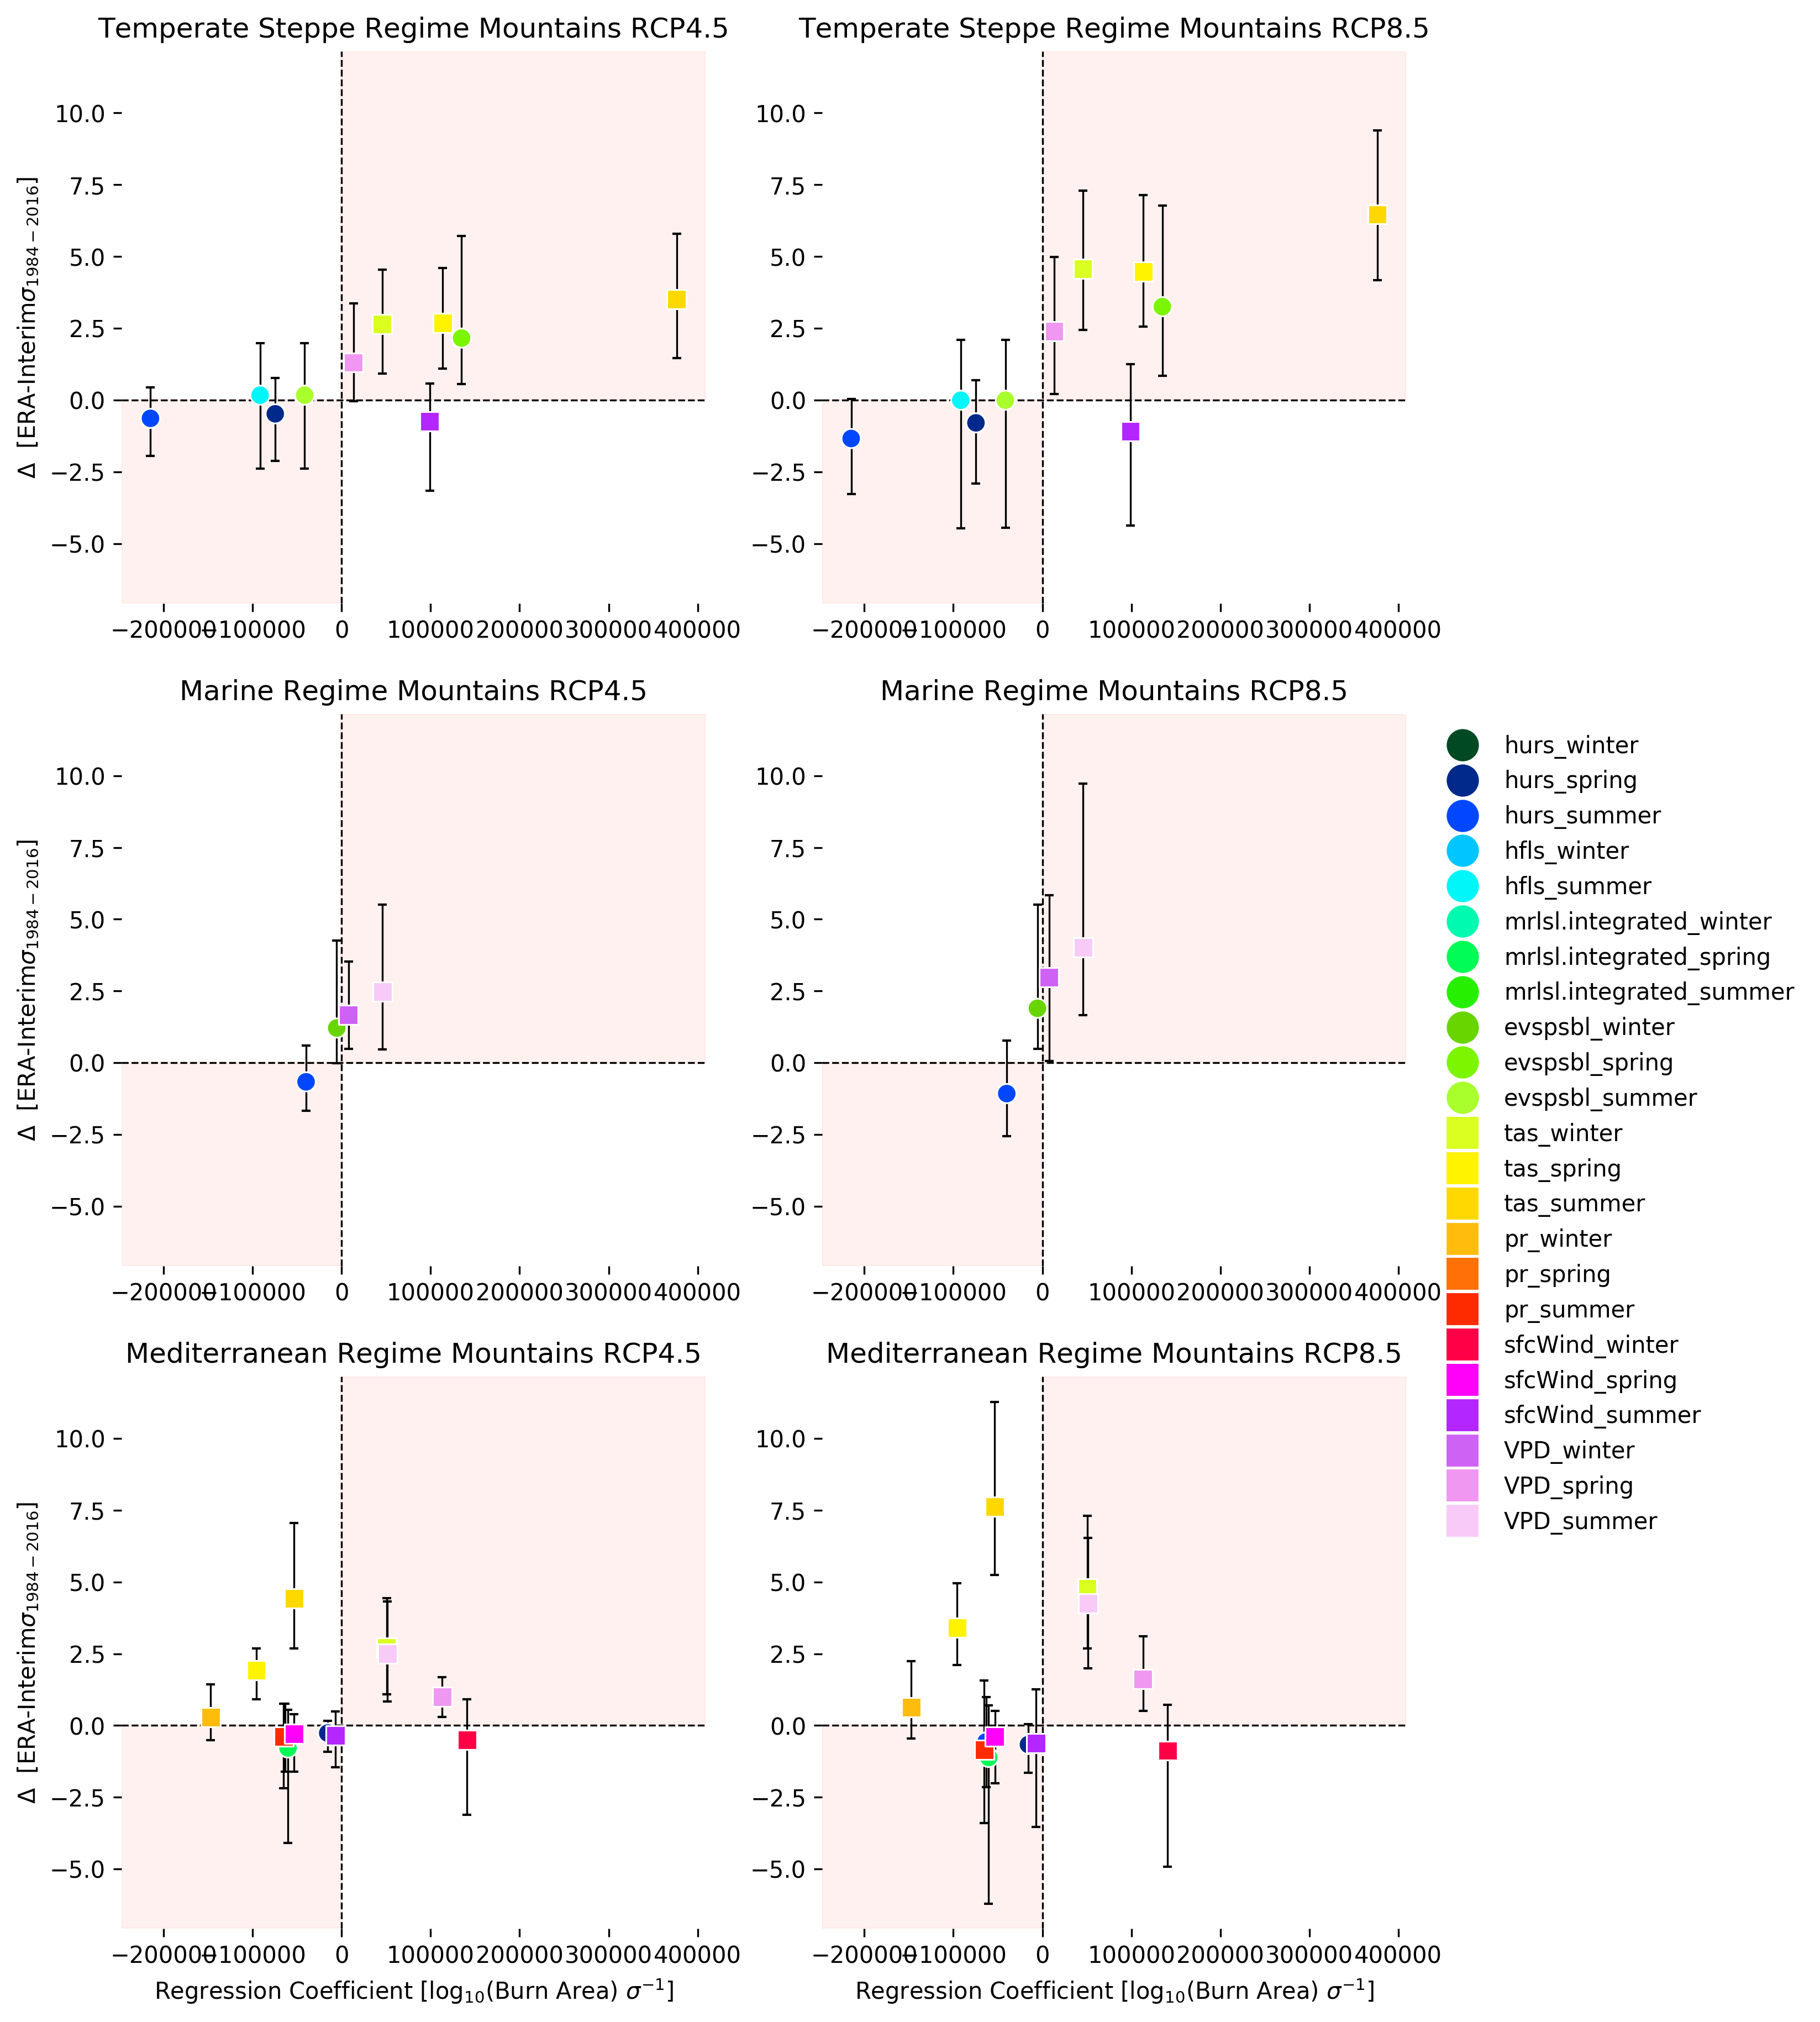

In [28]:
fig = plt.figure(dpi=300, figsize=(10,15))
plt.subplot(321)
ax1=plot_coef_vs_std("Temperate Steppe Regime Mountains", dataDir, "lasso_combined", 
                     scatter_df_45_dict["Temperate Steppe Regime Mountains"], 
                     return_fig=True, rcp="4.5", color_dict=color_dict)

plt.subplot(322, sharey=ax1, sharex=ax1)
ax2=plot_coef_vs_std("Temperate Steppe Regime Mountains", dataDir, "lasso_combined", 
                     scatter_df_85_dict["Temperate Steppe Regime Mountains"], 
                     return_fig=True, rcp="8.5", color_dict=color_dict)

plt.subplot(323, sharey=ax1, sharex=ax1)
ax3=plot_coef_vs_std("Marine Regime Mountains", dataDir, "lasso_combined", 
                     scatter_df_45_dict["Marine Regime Mountains"], 
                     return_fig=True, rcp="4.5", color_dict=color_dict)

plt.subplot(324, sharey=ax1, sharex=ax1)
ax4=plot_coef_vs_std("Marine Regime Mountains", dataDir, "lasso_combined", 
                     scatter_df_85_dict["Marine Regime Mountains"], 
                     return_fig=True, rcp="8.5", color_dict=color_dict)

plt.subplot(325, sharey=ax1, sharex=ax1)
ax5=plot_coef_vs_std("Mediterranean Regime Mountains", dataDir, "lasso_combined", 
                     scatter_df_45_dict["Mediterranean Regime Mountains"], 
                     return_fig=True, rcp="4.5", color_dict=color_dict)

plt.subplot(326, sharey=ax1, sharex=ax1)
ax6=plot_coef_vs_std("Mediterranean Regime Mountains", dataDir, "lasso_combined", 
                     scatter_df_85_dict["Mediterranean Regime Mountains"], 
                     return_fig=True, rcp="8.5", color_dict=color_dict)


# Do not show xaxis label for the top two rows
ax1.xaxis.label.set_visible(False)
ax2.xaxis.label.set_visible(False)
ax3.xaxis.label.set_visible(False)
ax4.xaxis.label.set_visible(False)

# Keep ylabel for only the left plots 1,3,5
ax2.yaxis.label.set_visible(False)
ax4.yaxis.label.set_visible(False)
ax6.yaxis.label.set_visible(False)

# Get/set require parameters for background shading
ymin, ymax = ax1.get_ylim()
xmin, xmax = ax1.get_xlim()
x0 = np.abs(xmin) / (np.abs(xmin)+np.abs(xmax))

tile_alpha = 0.5
tile_z = 0
down_color = "lavender"
up_color = "mistyrose"

# Set up looping through the panels 
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for ax in axes :
    ax.set_autoscale_on(False)
    #ax.axhspan(ymin=0, ymax=ymax, xmin=0, xmax=x0, color=down_color, zorder=tile_z, alpha=tile_alpha ) # Upper left
    #ax.axhspan(ymin=ymin, ymax=0, xmin=x0, xmax=1, color=down_color, zorder=tile_z, alpha=tile_alpha) # Lower right 
    ax.axhspan(ymin=ymin, ymax=0, xmin=0, xmax=x0, color=up_color, zorder=tile_z, alpha=tile_alpha) # Lower left 
    ax.axhspan(ymin=0, ymax=ymax, xmin=x0, xmax=1, color=up_color, zorder=tile_z, alpha=0.5) # upper right
    # Remove all individual legends 
    ax.legend_.remove()
    
    
plt.subplots_adjust(hspace=0.2, wspace=0.2)

ax4.legend(handles=feature_legend)
# Handle the legend
leg = ax4.get_legend()
# [left, bottom, width, height]
leg.set_bbox_to_anchor((0.2, 1, 1.5, 0.0))
leg.set_label(divisions.division)
leg.set_frame_on(False)

plt.savefig(os.path.join(dataDir, "lasso_combined_rcp_scatter_compare.png"), format='png', bbox_inches="tight")
plt.show()

#### Code for how I learned how to make custom legends

````Python 
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Line'),
                   Line2D([0], [0], marker='o', color='w', label='plant',
                          markerfacecolor='g', markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='atmos',
                          markerfacecolor='g', markersize=15),
                   Patch(facecolor='orange', edgecolor='r', label='Color Patch')]

# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=feature_legend, loc='center')

plt.show()

````

# Show these data together, using scatter, boxplots, & swarmplots

In [29]:
def make_delta_mean_df(df, rcp="8.5") :
    """
    Parameters
    ----------
        df : scatter df 
    """
    
    # Column attributes to describe the delta mean (sigma) values 
    value = []
    feature = []
    feature_type = [] 
    coef = []
    models = []
    feature_N = []
    division = []
    
    model_names = df.columns[9:].values
    variables = np.unique(df.index.values)

    #print(model_names)
    #print(variables)
    
    for var in variables :          # loop through features mean change 
        for model in model_names :  # for a given model

            value.append(df.loc[var, model])
            feature.append(var)
            feature_type.append(df.loc[var, "feature_type"])
            coef.append(df.loc[var, "coef"])
            division.append(df.loc[var, "division"])
            models.append(model)
            feature_N.append(df.loc[var, "feature_N"])
            
    coef = np.array(coef)
    sign = np.chararray((len(coef)), unicode=True)
    sign[:] = "- correlation"
    sign[coef > 0] = "+ correlation"
    

    return pd.DataFrame({"delta_mean":value, "feature":feature, 
                         "feature_type":feature_type, "coef":coef, "coef_sign":sign,
                         "division":division, "model":models, "feature_N":feature_N,
                         "rcp":rcp})

In [30]:
l85 = [make_delta_mean_df(scatter_df_85_dict['Marine Regime Mountains'], "8.5"),
       make_delta_mean_df(scatter_df_85_dict['Temperate Steppe Regime Mountains'], "8.5"),
       make_delta_mean_df(scatter_df_85_dict['Mediterranean Regime Mountains'], "8.5")
      ]

l45 = [make_delta_mean_df(scatter_df_45_dict['Marine Regime Mountains'], "4.5"),
       make_delta_mean_df(scatter_df_45_dict['Temperate Steppe Regime Mountains'], "4.5"),
       make_delta_mean_df(scatter_df_45_dict['Mediterranean Regime Mountains'], "4.5")
      ]

df_85_delta_mean = pd.concat(l85, axis=0, sort=False, ignore_index=True)
df_45_delta_mean = pd.concat(l45, axis=0, sort=False, ignore_index=True)

In [31]:
print(np.unique(df_85_delta_mean.rcp))
print(np.unique(df_45_delta_mean.rcp))

['8.5']
['4.5']


### Figure 4 (old signle RCP version)

### Plotting both RCPs together

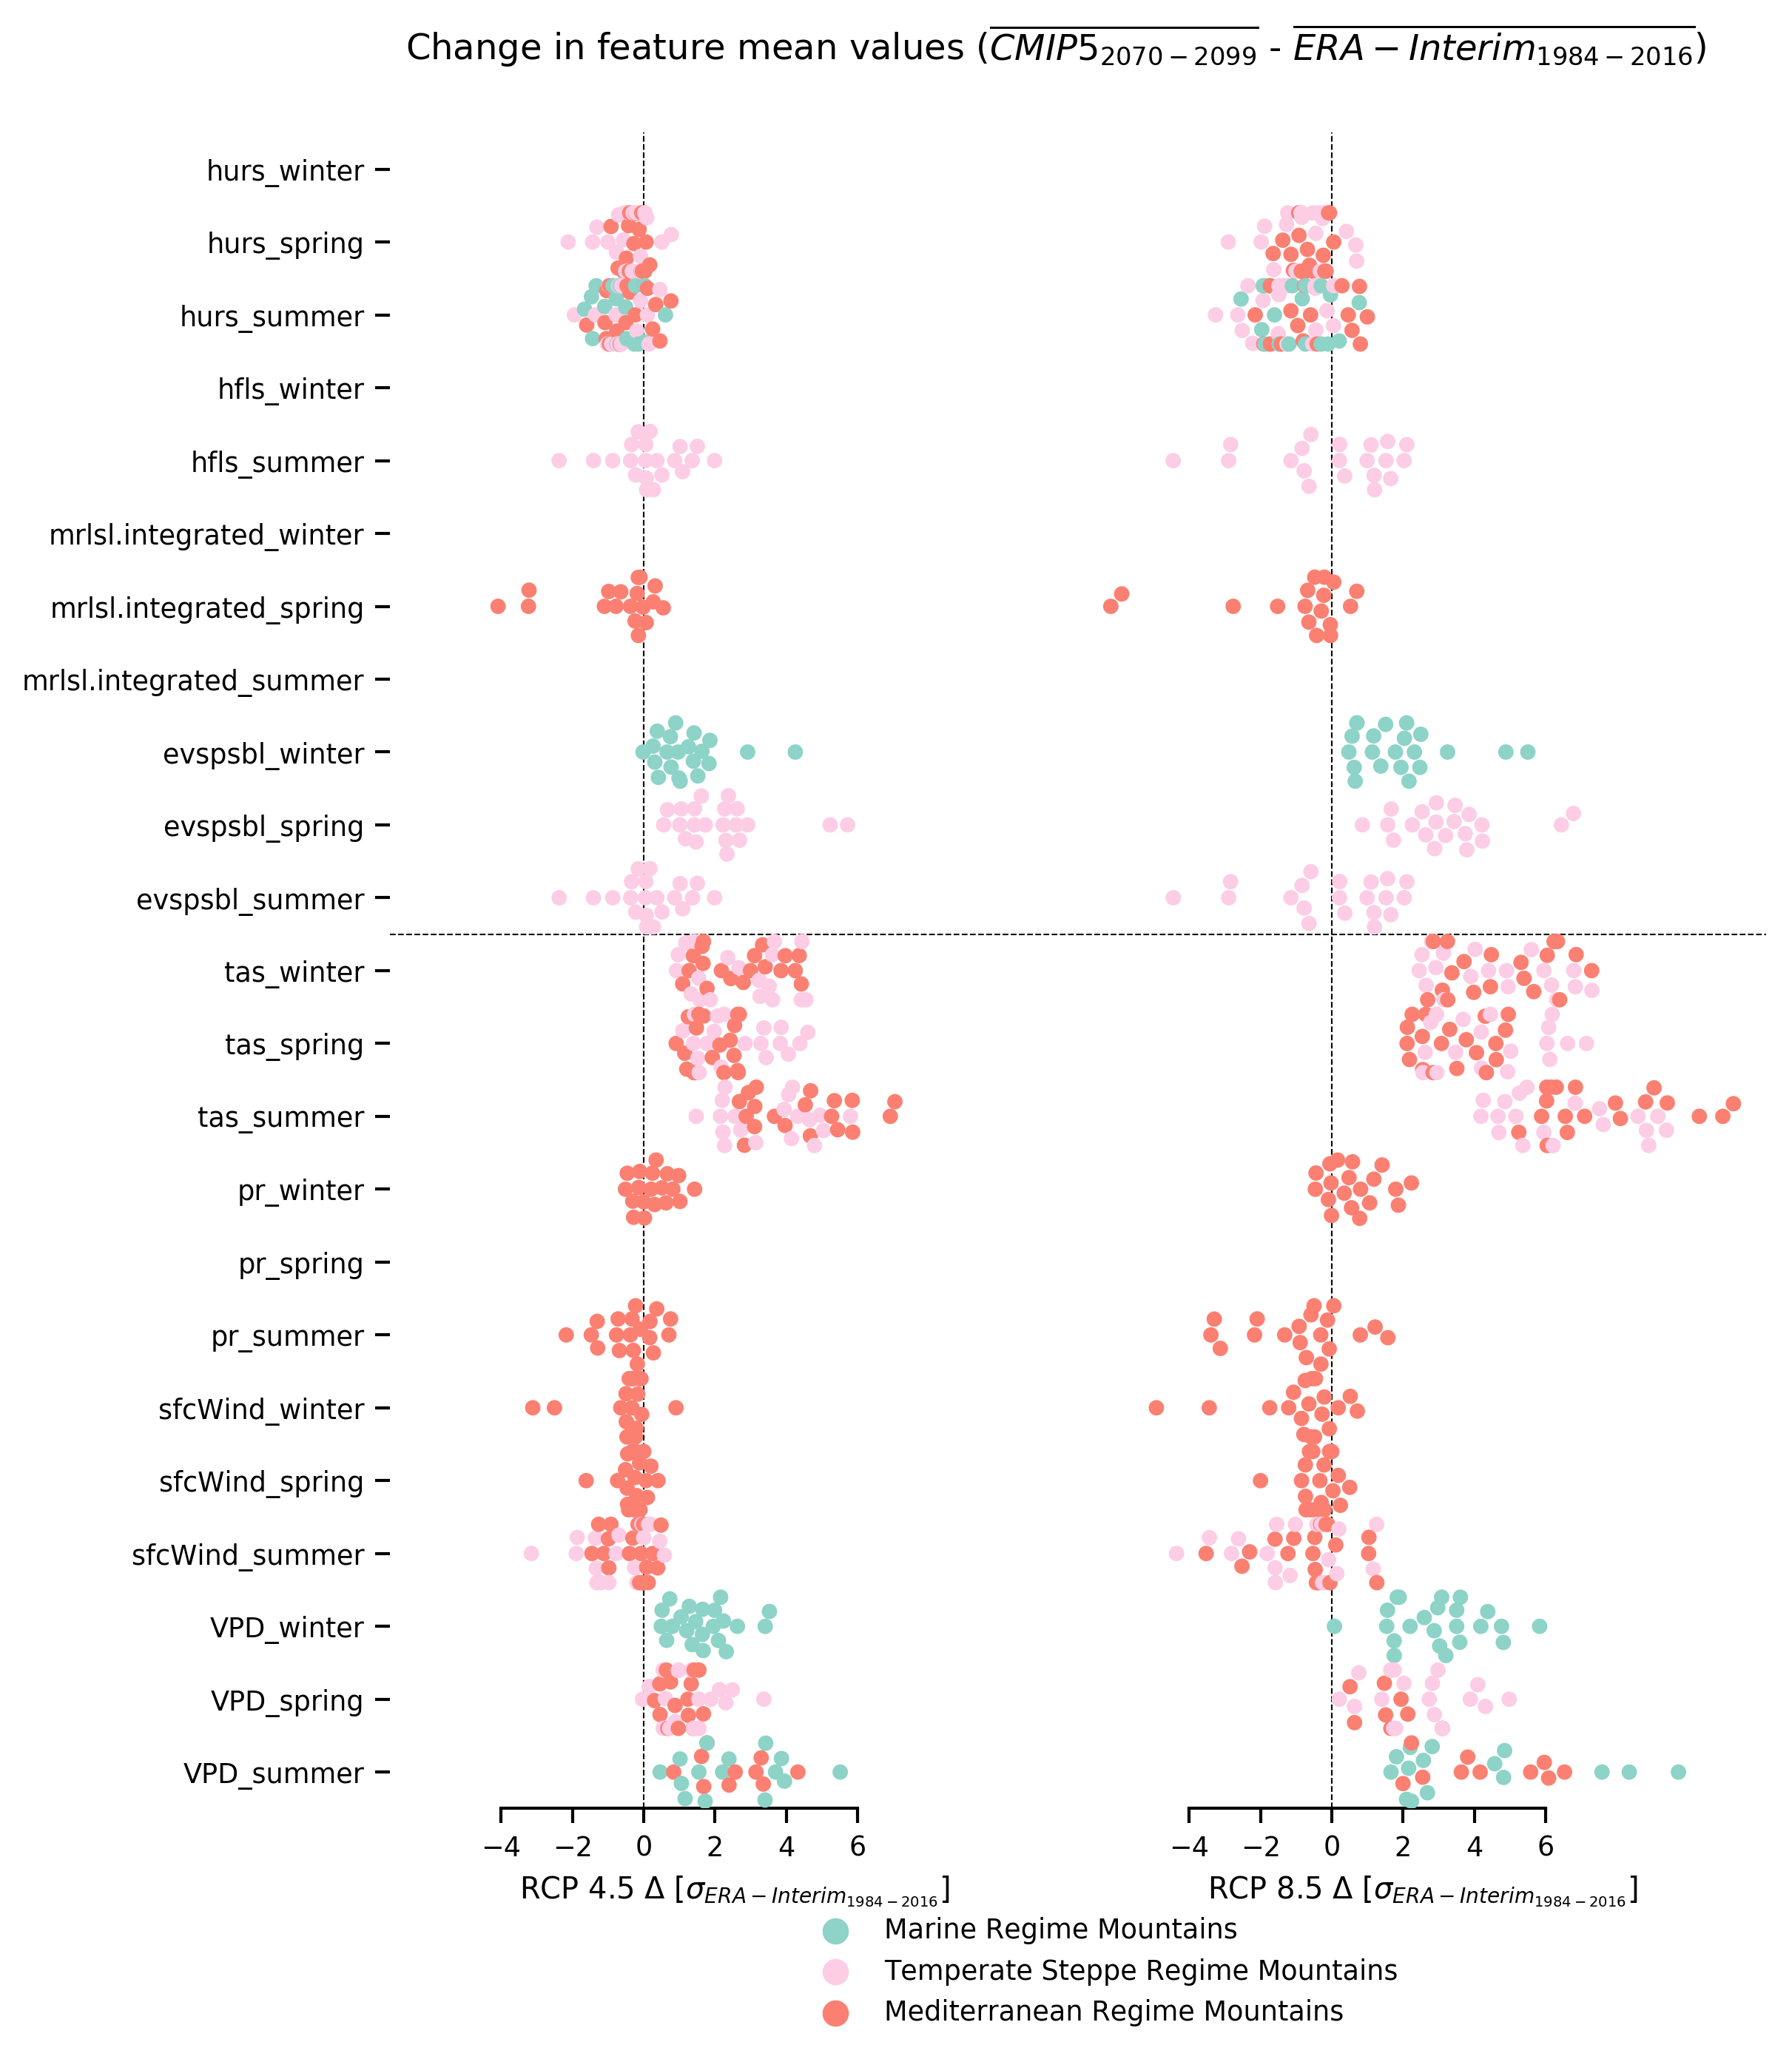

In [32]:
with sns.plotting_context("paper") :

    figure_name = "lasso_combined_delta_means_swamplot.png"
    
    # Set the order of the features for the plot 
    plot_order = lasso_combined_coefs.columns.values    
    # Figure out where to draw the line that separates plants from atmos
    last_plant_index = np.where(lasso_combined_coefs.columns.values == lasso_plant_coefs.columns[-1])[0][0]

    fig = plt.figure(dpi=300, figsize=(8,10))
    
    plt.subplot(1, 2, 1)
    
    ax1 = sns.swarmplot(y="feature", x="delta_mean", 
                       hue="division", order=plot_order,
                       data=df_45_delta_mean, palette=div_color_dict)
    # dodge=True, will stack the colors 

    #ax.xaxis.grid(True)
    ax1.set(xlabel="RCP 4.5 $\Delta$ [$\sigma_{ERA-Interim_{1984-2016}}$]")
    ax1.set(ylabel="")
    sns.despine(trim=True, left=True)

    #plt.xticks(rotation=90)
    plt.axvline(x=0, linestyle="--", color="k", linewidth=0.5)
    plt.axhline(y=(last_plant_index + 0.5) , linestyle="--", color="k", linewidth=0.5)

    # Handle the legend
    leg = ax1.get_legend()
    # [left, bottom, width, height]
    leg.set_bbox_to_anchor((1.0, 0.45, 0.5, -0.5))
    leg.set_label(divisions.division)
    leg.set_title("")
    leg.set_frame_on(False)
    
    ################################################################
    # Second panel 
    plt.subplot(122, sharex=ax1, sharey=ax1)
    ax2 = sns.swarmplot(y="feature", x="delta_mean", 
                        hue="division", order=plot_order,
                        data=df_85_delta_mean, palette=div_color_dict)
    sns.despine(trim=True, left=True)
    plt.axvline(x=0, linestyle="--", color="k", linewidth=0.5)
    plt.axhline(y=(last_plant_index + 0.5) , linestyle="--", color="k", linewidth=0.5)
    ax2.set(ylabel="")
    ax2.set(xlabel="RCP 8.5 $\Delta$ [$\sigma_{ERA-Interim_{1984-2016}}$]")
    # ax2.set(yticklabels=[]) # romoves ylabels for first pabel too
    ax2.yaxis.set_visible(False)
    ax2.legend_.remove()
    
    # Reduce the distance between the columns for subplots 
    plt.subplots_adjust(wspace=0.0)
    
    # Make labels bold 
    #plt.rcParams['axes.labelweight'] = 'bold'
    
    fig.suptitle("Change in feature mean values ($\overline{CMIP5_{2070-2099}}$ - $\overline{ERA-Interim_{1984-2016}}$)",
                y=0.93)
    
    plt.savefig(os.path.join(dataDir, figure_name),  bbox_inches='tight')
    
    plt.show()

Here is an idea for presenting the distribution as well as the raw values while color coding the sign of the coef that brought these features into the plot. 
### TODO: Bring this boxplot version back, where we show the raw feature values for the future decade. Not the mean change from training period.  

### Burn area visualization 

Here is how the two RCPs can be displayed together! This will be done by adding RCP as an attribute and changing the "col" parameter to "rcp" column of the df_delta_mean.

Possible way to make ranked boxplot needed. 
https://stackoverflow.com/questions/39214484/how-to-rank-plot-in-seaborn-boxplot

#### Handy functions for burn area plots 

In [33]:
def get_BA_dict(regression_name, rcp) :
    """
    Function for loading pickled burn area dictionaries for different
    regressions and scenarios. 
    """
    
    # Get the CMIP5 features expressed in terms of historical variance "Z_dict"
    # or their raw values averaged in a region ""
    f = regression_name + "_BA_rcp" + rcp + '.obj'
    #print("Getting " + f)
    with open(os.path.join(dataDir, f), 'rb') as fp:
        d = pickle.load(fp)
    return d 

def ensemble_stats(BA) : 
    return BA.mean(axis=1), BA.min(axis=1), BA.max(axis=1)

def make_arrow_points(y1, y2) :
    """
    y1 : series one to be averaged
    y2 : series two to be average
    
    Returns coordinates to draw arrows illistrating the distance
    betwen the mean of y1 y2 series. 
    """
    
    y1 = np.mean(y1)
    y2 = np.mean(y2)
    
    # TODO: Add functionality to average over specified years 
    delta = np.abs(y1 - y2)
    ymin = np.min([y1 , y2])
    ymax = np.max([y1 , y2])
    
    return delta, ymin, ymax

def get_historic_burn_area(div) :
    """Get historic burn area for a division"""
    with open(os.path.join(dataDir, "div_log10_burn_area_dict.obj"), 'rb') as fp:
        div_log10_burn_area = pickle.load(fp)
    return div_log10_burn_area[div]

In [34]:
# https://stackoverflow.com/questions/31671999/python-different-size-subplots-in-matplotlib?rq=1
def burn_area_projections(div, div_BA_atmos_45, div_BA_atmos_85, div_BA_plant_45, div_BA_plant_85) :

    ############################################################
    # Get data needed for plot 
    mtbs_BA = get_historic_burn_area(div)
    
    # Calculate the ensemble means! 
    BA_atmos_means_45, _, _ = ensemble_stats(div_BA_atmos_45)
    BA_atmos_means_85, _, _ = ensemble_stats(div_BA_atmos_85)
    BA_plant_means_45, _, _ = ensemble_stats(div_BA_plant_45)
    BA_plant_means_85, _, _ = ensemble_stats(div_BA_plant_85)
    
    fig=plt.figure(figsize=(10,5), dpi=300)

    gs=GridSpec(2,3) # 2 rows, 3 columns

    #############################################################
    ax1=fig.add_subplot(gs[0,0:3]) # Time series

    # Plot atmos
    plt.plot(BA_atmos_means_45, color="C1", linestyle="-", label="Atmospheric-Centric")
    plt.plot(BA_atmos_means_85, color="C1", linestyle="--")
    # Plot plant
    plt.plot(BA_plant_means_45, color="green", linestyle="-", label="Plant-Centric")
    plt.plot(BA_plant_means_85, color="green", linestyle="--")

    # Style components 
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    plt.ylabel("log$_{10}$(Burn Area [acres])")
    plt.title( div)
    
    legend_elements = [Line2D([0], [0], color='k', lw=1, linestyle="--", label='RCP 8.5'),
                       Line2D([0], [0], color='k', lw=1, linestyle="-", label='RCP 4.5'),
                       Line2D([0], [0], marker='s', color='w', label='plant-centric', markerfacecolor='g', markersize=15),
                       Line2D([0], [0], marker='s', color='w', label='atmospheric-centric', markerfacecolor='C1', markersize=15),
                       Line2D([0], [0], marker='s', color='w', label='Observed', markerfacecolor='C0', markersize=15)]

    # Create the figure
    ax1.legend(handles=legend_elements, loc='upper left', frameon=False, prop={'size': 9})
    
    # "ensemble mean burn area in" + " " +
    #############################################################
    #ax2=fig.add_subplot(gs[0,3], sharey=ax1) # Arrows on end of time series 

    #lwd = 3
    #delta_atmos_rcp, ymin_atmos_rcp, ymax_atmos_rcp = make_arrow_points(BA_atmos_means_85.iloc[-1], BA_atmos_means_45.iloc[-1])
    #plt.arrow(x=0.1, y=ymin_atmos_rcp, dx=0, dy=delta_atmos_rcp, color='C1', head_length = 0.1, head_width = 0.1, linewidth=lwd,length_includes_head = True)
    #plt.arrow(x=0.1, y=ymax_atmos_rcp, dx=0, dy=-delta_atmos_rcp, color='C1', head_length = 0.1, head_width = 0.1,linewidth=lwd, length_includes_head = True)
    #plt.text(0.11, (ymin_atmos_rcp+ymax_atmos_rcp)/2., s="RCP spread", color="C1", fontsize=7)

    #delta_plant_rcp, ymin_plant_rcp, ymax_plant_rcp = make_arrow_points(BA_plant_means_85.iloc[-1], BA_plant_means_45.iloc[-1])
    #plt.arrow(x=0.3, y=ymin_plant_rcp, dx=0, dy=delta_plant_rcp, color='green', head_length = 0.1, head_width = 0.1, length_includes_head = True, linewidth=lwd)
    #plt.arrow(x=0.3, y=ymax_plant_rcp, dx=0, dy=-delta_plant_rcp, color='green', head_length = 0.1, head_width = 0.1, length_includes_head = True, linewidth=lwd)
    #plt.text(0.31, (ymin_plant_rcp+ymax_plant_rcp)/2., s="RCP spread", color="green", fontsize=7)

    # Difference in regressions from RCP85
    #delta_regression_85, ymin_regression_85, ymax_regression_85 = make_arrow_points(BA_plant_means_85.iloc[-1], BA_atmos_means_85.iloc[-1])
    #plt.arrow(x=0.5, y=ymin_regression_85, dx=0, dy=delta_regression_85, color='green', head_length = 0.1, head_width = 0.1, length_includes_head = True, linestyle="-", linewidth=lwd)
    #plt.arrow(x=0.52, y=ymax_regression_85, dx=0, dy=-delta_regression_85, color='C1', head_length = 0.1, head_width = 0.1, length_includes_head = True, linestyle="-", linewidth=lwd)
    #plt.text(0.54, (ymin_regression_85+ymax_regression_85)/2.-.1, s="Regression spread\nfor RCP8.5", color="k", fontsize=7)

    # Difference in regressions from RCP45
    #delta_regression_45, ymin_regression_45, ymax_regression_45 = make_arrow_points(BA_plant_means_45.iloc[-1], BA_atmos_means_45.iloc[-1])
    #plt.arrow(x=0.7, y=ymin_regression_45, dx=0, dy=delta_regression_45, color='green', head_length = 0.1, head_width = 0.1, length_includes_head = True, linestyle="-", linewidth=lwd)
    #plt.arrow(x=0.72, y=ymax_regression_45, dx=0, dy=-delta_regression_45, color='C1', head_length = 0.1, head_width = 0.1, length_includes_head = True, linestyle="-", linewidth=lwd)
    #plt.text(0.731, (ymin_regression_45+ymax_regression_45)/2.-.1, s="Regression spread\nfor RCP4.5", color="k", fontsize=7)

    #plt.title("Spread in 2100")
    #plt.axis('off')

    #############################################################
    ax3=fig.add_subplot(gs[1,0]) # Second row, span all columns
    plt.xlabel("1984-2016")

    # Get Models attempt at historical prediction
    x1 = div_BA_atmos_45.loc[1984:2016, :].values.ravel()
    x2 = div_BA_atmos_85.loc[1984:2016, :].values.ravel()
    x3 = div_BA_plant_45.loc[1984:2016, :].values.ravel()
    x4 = div_BA_plant_85.loc[1984:2016, :].values.ravel()
    
    boxData = [mtbs_BA, x1, x2, x3, x4]
    labels  = ["MTBS", "4.5", "8.5", "4.5", "8.5"]
    colors  = ["C0","C1", "C1", "green", "green"]
    
    box = plt.boxplot(boxData, labels=labels,
                      medianprops = dict(linestyle='-', linewidth=1., color='k'),
                      notch=True, patch_artist=True)
    # Paint the boxes 
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.ylabel("log$_{10}$(Burn Area [acres])")

    ax3.spines['right'].set_visible(False)    
    ax3.spines['left'].set_visible(False)    
    ax3.spines['top'].set_visible(False)    
    ax3.spines['bottom'].set_visible(False)    

    #############################################################
    ax4=fig.add_subplot(gs[1,1], sharey=ax3)
    plt.xlabel("2040-2060")

    x1 = div_BA_atmos_45.loc[2040:2060, :].values.ravel()
    x2 = div_BA_atmos_85.loc[2040:2060, :].values.ravel()
    x3 = div_BA_plant_45.loc[2040:2060, :].values.ravel()
    x4 = div_BA_plant_85.loc[2040:2060, :].values.ravel()

    boxData = [x1, x2, x3, x4]

    colors = ["C1", "C1", "green", "green"]
    labels = ["4.5", "8.5", "4.5", "8.5"]
    box = plt.boxplot(boxData, labels=labels,
                      medianprops = dict(linestyle='-', linewidth=1., color='k'),
                      notch=True, patch_artist=True)
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    ax4.spines['right'].set_visible(False)    
    ax4.spines['left'].set_visible(False)    
    ax4.spines['top'].set_visible(False)    
    ax4.spines['bottom'].set_visible(False)    
    ax4.axes.get_yaxis().set_visible(False)

    #############################################################
    ax5=fig.add_subplot(gs[1,2], sharey=ax4)
    plt.xlabel("2080-2100")

    x1 = div_BA_atmos_45.loc[2080:2100, :].values.ravel()
    x2 = div_BA_atmos_85.loc[2080:2100, :].values.ravel()
    x3 = div_BA_plant_45.loc[2080:2100, :].values.ravel()
    x4 = div_BA_plant_85.loc[2080:2100, :].values.ravel()

    boxData = [x1, x2, x3, x4]

    colors = ["C1", "C1", "green", "green"]
    labels = ["4.5", "8.5", "4.5", "8.5"]
    box = plt.boxplot(boxData, labels=labels,
                      medianprops = dict(linestyle='-', linewidth=1., color='k'),
                      notch=True, patch_artist=True)
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    ax5.spines['right'].set_visible(False)    
    ax5.spines['left'].set_visible(False)    
    ax5.spines['top'].set_visible(False)    
    ax5.spines['bottom'].set_visible(False)    
    ax5.axes.get_yaxis().set_visible(False)

    #############################################################
    #ax6=fig.add_subplot(gs[1,3]) # Second row, span all columns
    #plt.axis('off')

    #legend_elements = [Line2D([0], [0], color='k', lw=1, linestyle="--", label='RCP 8.5'),
    #                   Line2D([0], [0], color='k', lw=1, linestyle="-", label='RCP 4.5'),
    #                   Line2D([0], [0], marker='s', color='w', label='plant-centric', markerfacecolor='g', markersize=15),
    #                   Line2D([0], [0], marker='s', color='w', label='atmospheric-centric', markerfacecolor='C1', markersize=15),
    #                   Line2D([0], [0], marker='s', color='w', label='Historic/Observed', markerfacecolor='C0', markersize=15)]

    # Create the figure
    #ax6.legend(handles=legend_elements, loc='center', frameon=False)

    #plt.subplots_adjust(wspace=0.6) # reduce spaces between panes
    fig.tight_layout()

    f = os.path.join(dataDir, "lasso_combined_" + div.replace("/"," ") + '_burn_area_projections.png')
    fig.savefig(f)
    plt.close()
    
    return fig, f 


### Get burn area data
- load the dictionary for both regression types and RCPs (4 total)
- subset to division of interest
- calculate esemble means

In [35]:
# Get burn area dictionary (keys are divisions)
lasso_atmos_BA_45 = get_BA_dict("lasso_atmos", "45")
lasso_atmos_BA_85 = get_BA_dict("lasso_atmos", "85")
lasso_plant_BA_45 = get_BA_dict("lasso_plant", "45")
lasso_plant_BA_85 = get_BA_dict("lasso_plant", "85")

In [36]:
div = "Temperate Steppe Regime Mountains"
row1, f1 = burn_area_projections(div, lasso_atmos_BA_45[div], lasso_atmos_BA_85[div], 
                             lasso_plant_BA_45[div], lasso_plant_BA_85[div])

In [37]:
div = "Marine Regime Mountains"
row2, f2 = burn_area_projections(div, lasso_atmos_BA_45[div], lasso_atmos_BA_85[div], 
                             lasso_plant_BA_45[div], lasso_plant_BA_85[div])

In [38]:
div = "Mediterranean Regime Mountains"
row3, f3 = burn_area_projections(div, lasso_atmos_BA_45[div], lasso_atmos_BA_85[div], 
                             lasso_plant_BA_45[div], lasso_plant_BA_85[div])

In [39]:
# Combine desired outputs with information in this thread
# https://stackoverflow.com/questions/30227466/combine-several-images-horizontally-with-python

# for a vertical stacking it is simple: use vstack
import PIL
list_im = [f1, f2, f3]
imgs    = [ PIL.Image.open(i) for i in list_im ]

# pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )

imgs_comb = np.vstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb.save( os.path.join(dataDir, 'burn_area_projections_mountains.png') )

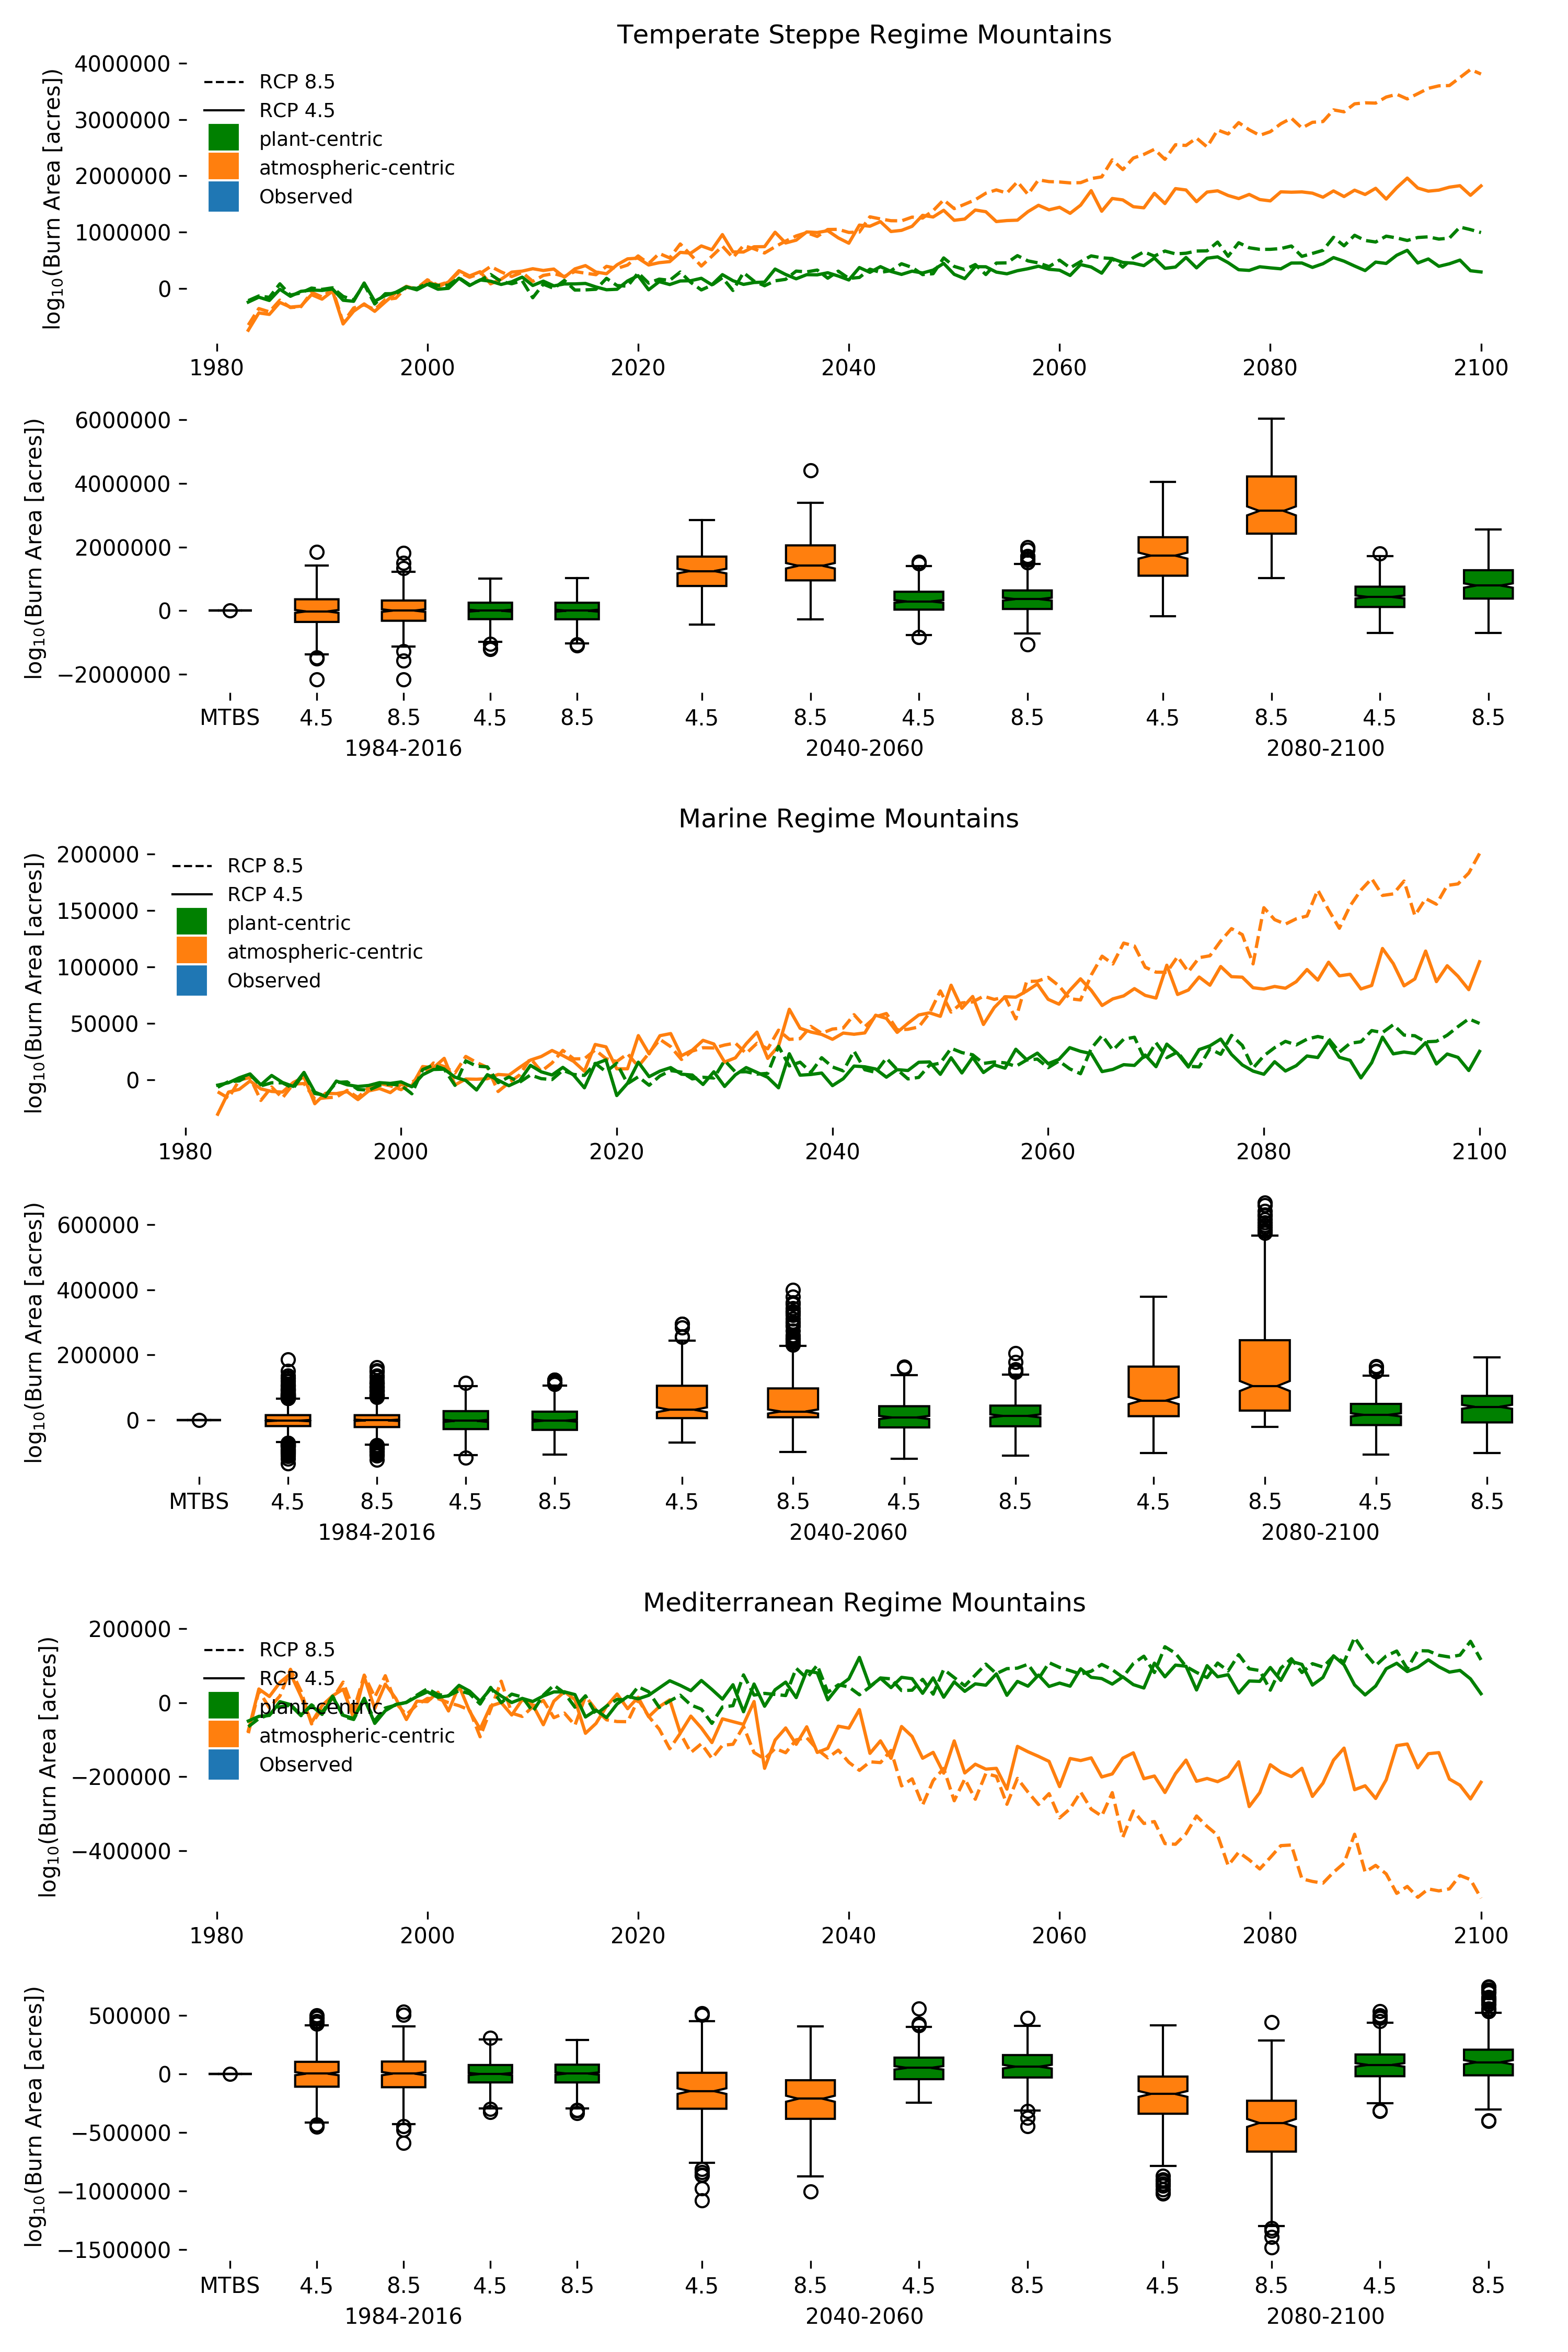

In [40]:
from IPython.display import Image
Image(os.path.join(dataDir, 'burn_area_projections_mountains.png'))

**Figure 5:** (Beta) Temperate Steppe Regime Mountains (top), Marine Regime Mountains (middle), and Mediterranean Regime Mountains (bottom) burn area projections using lasso regression trained with plant- and atmospheric-centric predictors for RCPs 4.5 and 8.5. The line plots show the ensemble mean of individual CMIP5 model burn area projections for a given regression type and RCP. Right of each time series there are arrows that show the spread in estimated burn area for the year 2100 across RCPs and regression types. Below the time series, box plots that show the distribution of individual summer burn area estimates from all available CMIP5 models for the years indicated on the horizontal axis label. These distributions are separated by regression type (color) as well as RCP ( horizontal axis tick labels). 

In [94]:
lasso_atmos_BA_45.keys()

dict_keys(['Marine Regime Mountains', 'Temperate Desert Division', 'Temperate Steppe Regime Mountains', 'Tropical/Subtropical Desert Division', 'Tropical/Subtropical Steppe Division', 'Tropical/Subtropical Regime Mountains', 'Mediterranean Regime Mountains', 'western_US'])

In [95]:
div = 'Temperate Desert Division'
_, _ = burn_area_projections(div, lasso_atmos_BA_45[div], lasso_atmos_BA_85[div], 
                             lasso_plant_BA_45[div], lasso_plant_BA_85[div])

In [96]:
 for div in lasso_atmos_BA_45.keys() :
    try :
        _, _ = burn_area_projections(div, lasso_atmos_BA_45[div], lasso_atmos_BA_85[div], lasso_plant_BA_45[div], lasso_plant_BA_85[div])
        
    except  :
        
        print("something went wrong with  " + div)

something went wrong with  Tropical/Subtropical Steppe Division
